In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, GridSearchCV, KFold
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import clone
from sklearn.metrics import confusion_matrix, auc, ConfusionMatrixDisplay, classification_report, accuracy_score
from tabulate import tabulate
from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import StandardScaler
import pickle
import nilearn.datasets
# from utils import get_data

import random
import os

# --- SET SEED ---
# Choose a seed value
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
print(f"Using random seed: {SEED}")

# --- SET PATH ---
import sys
from pathlib import Path
SRC_DIR = Path.cwd().parent / 'src'
if str(SRC_DIR) not in sys.path:
    sys.path.append(str(SRC_DIR))
    print(f"Added {SRC_DIR} to sys.path")

from data_loading import load_and_split_fmri_data
from modeling import CustomGridSearch, EvaluationPipeline, CrossEvaluationPipeline, MultiClassEvaluator

Using random seed: 42
Added /Users/kulkarnik/LocalProjects/multiclassifier_repo/src to sys.path


### CONFIGURATION

In [2]:
import os
import logging # Add logging import if not already there
from pathlib import Path

# --- Core Project Structure ---
BASE_DIR = Path.cwd().parent # Assume the script is in a notebooks/ subdir under the base directory
DATA_DIR = BASE_DIR / "data"
RAW_DATA_DIR = DATA_DIR / "raw"
INTERIM_DATA_DIR = DATA_DIR / "interim"
PROCESSED_DATA_DIR = DATA_DIR / "processed"
METADATA_DIR = DATA_DIR / "metadata" # For subject lists, etc.
MODELS_DIR = BASE_DIR / "models"
REPORTS_DIR = BASE_DIR / "reports"
FIGURE_DIR = REPORTS_DIR / "figures" # Specific subdir for figures

In [3]:
# --- Specific Paths Used in this Notebook ---

# Input Data Files
SUBJECT_LIST_DIR = METADATA_DIR
SUBJECT_LIST_FILE = SUBJECT_LIST_DIR / "gender_controlled_splits.csv"

# Location of raw Functional Connectivity .npy files
RAW_FC_DIR = RAW_DATA_DIR / "all_parcellations" # Recommended location

# File patterns for FC files within RAW_FC_DIR
ALC_FILE_PATTERN = "{sub}_residuals_run_{run}_connectivity_matrix_100.npy" # Check if this needs 'sub-' prefix?
CAN_FILE_PATTERN = "sub-{sub}_run-{run}_corr-100.npy"

# Intermediate processed data (saved by data loading function)
PROCESSED_DATA_NPZ = INTERIM_DATA_DIR / "functional_connectivity_processed.npz"

# Saved Model Files (.pkl) - Place under models/
ALCOHOL_MODEL_PKL = MODELS_DIR / "alcohol_classifier_weights.pkl"
CANNABIS_MODEL_PKL = MODELS_DIR / "cannabis_classifier_weights.pkl"
AGGREGATED_MODEL_PKL = MODELS_DIR / "aggregated_classifier_weights.pkl"
THREECLASS_ONEVONE_PKL = MODELS_DIR / "threeclass_onevone_classifier_weights.pkl"
THREECLASS_ONEVREST_PKL = MODELS_DIR / "threeclass_onevrest_classifier_weights.pkl"

# Saved Figures (.svg) - Place under reports/figures/
ALC_ROC_FIG = FIGURE_DIR / "alc_classifier_roc_curve.svg"
CAN_ROC_FIG = FIGURE_DIR / "can_classifier_roc_curve.svg"
# Maybe make cross-classification filename more specific?
CROSS_ROC_FIG = FIGURE_DIR / "cross_can_train_alc_test_roc_curve.svg" # Example
AGG_ROC_FIG = FIGURE_DIR / "aggregated_classifier_roc_curve.svg"
MULTICLASS_OVO_CM_FIG = FIGURE_DIR / "onevone_multi_classifier_confusion_matrix.svg"
MULTICLASS_OVR_CM_FIG = FIGURE_DIR / "onevrest_multi_classifier_confusion_matrix.svg"

In [4]:
# --- Ensure Key Directories Exist ---
# Create directories if they don't exist to avoid errors during saving
INTERIM_DATA_DIR.mkdir(parents=True, exist_ok=True)
PROCESSED_DATA_DIR.mkdir(parents=True, exist_ok=True) # If you use it
METADATA_DIR.mkdir(parents=True, exist_ok=True) # If you move subject lists
MODELS_DIR.mkdir(parents=True, exist_ok=True)
FIGURE_DIR.mkdir(parents=True, exist_ok=True)

In [5]:
# --- Hyperparameters & Settings (Keep from previous step) ---
GRIDSEARCH_CV_FOLDS = 5
CLASSIFICATION_CV_FOLDS = 5
MAX_ITER_GRIDSEARCH = 100000
MAX_ITER_TRAINING = 10000
SGD_ALPHAS_GRID = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0, 10.0]

DEFAULT_L1_LOGISTIC_ALPHA = 0.001
DEFAULT_L2_LOGISTIC_ALPHA = 0.001
DEFAULT_L1_HINGE_ALPHA = 0.001
DEFAULT_L2_HINGE_ALPHA = 0.001

RANDOM_STATE_GRIDSEARCH = 1234
RANDOM_STATE_PIPELINE = 52
RANDOM_STATE_CROSS = 1
RANDOM_STATE_AGG = 52
RANDOM_STATE_MULTICLASS = 52
RANDOM_STATE_KFOlD = 150 # For the KFold inside ClassifierPipeline

MULTICLASS_LABELS = ['HC', 'Cannabis', 'Alcohol'] # Assumed mapping
ALCOHOL_CLASS_LABEL_MULTI = 2 # Label assigned to alcohol in 3-way

In [6]:
# --- Verification ---
print(f"Project Base Directory: {BASE_DIR}")
print(f"Raw FC Data Directory: {RAW_FC_DIR}")
print(f"Subject List File: {SUBJECT_LIST_FILE}")
print(f"Saving Models to: {MODELS_DIR}")
print(f"Saving Figures to: {FIGURE_DIR}")
print(f"Saving Processed NPZ to: {PROCESSED_DATA_NPZ}")

# Check if key input paths exist
if not RAW_FC_DIR.is_dir():
     logging.warning(f"Raw data directory NOT FOUND: {RAW_FC_DIR}")
if not SUBJECT_LIST_FILE.is_file():
     logging.warning(f"Subject list file NOT FOUND: {SUBJECT_LIST_FILE}")

Project Base Directory: /Users/kulkarnik/LocalProjects/multiclassifier_repo
Raw FC Data Directory: /Users/kulkarnik/LocalProjects/multiclassifier_repo/data/raw/all_parcellations
Subject List File: /Users/kulkarnik/LocalProjects/multiclassifier_repo/data/metadata/gender_controlled_splits.csv
Saving Models to: /Users/kulkarnik/LocalProjects/multiclassifier_repo/models
Saving Figures to: /Users/kulkarnik/LocalProjects/multiclassifier_repo/reports/figures
Saving Processed NPZ to: /Users/kulkarnik/LocalProjects/multiclassifier_repo/data/interim/functional_connectivity_processed.npz


### LOAD DATA

In [7]:
print(f"Loading subject list from: {SUBJECT_LIST_FILE}")
subject_list_df = pd.read_csv(SUBJECT_LIST_FILE, index_col=0)
print(f"Subject list loaded with {len(subject_list_df)} entries.")
subject_list_df.head() # Display the first few rows of the DataFrame

Loading subject list from: /Users/kulkarnik/LocalProjects/multiclassifier_repo/data/metadata/gender_controlled_splits.csv
Subject list loaded with 523 entries.


,level_0,subject,index,group,inclusion,label,training,total_fd_spikes,total_rot_spikes,total_trans_spikes,Percent Spikes,rmsd_mean_1,rmsd_mean_2,rmsd_max_1,rmsd_max_2,age,sex
0,215,020053,381.0,cannabis,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.146789,0.146789,0.672840,0.712712,NaN,NaN
1,216,020072,382.0,cannabis,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.072957,0.072957,0.417171,1.893430,NaN,NaN
2,217,020160,383.0,cannabis,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.063517,0.063517,0.263958,0.456234,NaN,NaN
3,218,020202,384.0,cannabis,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.134204,0.134204,0.694702,0.405649,NaN,NaN
4,219,020441,385.0,cannabis,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.054719,0.054719,0.234727,0.336701,NaN,NaN


In [8]:
print("Loading and splitting feature data using refactored function...")
(   (X_train, X_test, y_train, y_test, train_ids, test_ids),
    (alc_X_train, alc_X_test, alc_y_train, alc_y_test, alc_train_ids, alc_test_ids),
    (can_X_train, can_X_test, can_y_train, can_y_test, can_train_ids, can_test_ids)
) = load_and_split_fmri_data(
        config_df=subject_list_df,     
        data_dir=RAW_FC_DIR,           
        alc_file_pattern=ALC_FILE_PATTERN, 
        can_file_pattern=CAN_FILE_PATTERN,
        output_npz_path=PROCESSED_DATA_NPZ
)

print("Data loading and splitting complete.")
# The logging messages from the function will show details/warnings.
# You can keep the shape printouts here if you like.

2025-04-20 23:31:38,266 - INFO - Loading Alcohol group data...


Loading and splitting feature data using refactored function...


2025-04-20 23:31:38,429 - INFO - Loaded 320 matrices for group Alcohol. Skipped 94 files.
2025-04-20 23:31:38,447 - INFO - Loading Cannabis group data...
2025-04-20 23:31:38,630 - INFO - Loaded 411 matrices for group Cannabis. Skipped 191 files.
2025-04-20 23:31:38,662 - INFO - Saved processed data to: /Users/kulkarnik/LocalProjects/multiclassifier_repo/data/interim/functional_connectivity_processed.npz
2025-04-20 23:31:38,668 - INFO - Final Shapes - Aggregated: X_train=(579, 4950), y_train=(579,), X_test=(152, 4950), y_test=(152,), train_ids=(579,), test_ids=(152,)
2025-04-20 23:31:38,668 - INFO - Final Shapes - Alcohol: alc_X_train=(256, 4950), alc_y_train=(256,), alc_X_test=(64, 4950), alc_y_test=(64,), alc_train_ids=(256,), alc_test_ids=(64,)
2025-04-20 23:31:38,668 - INFO - Final Shapes - Cannabis: can_X_train=(323, 4950), can_y_train=(323,), can_X_test=(88, 4950), can_y_test=(88,), can_train_ids=(323,), can_test_ids=(88,)


Data loading and splitting complete.


## ALCOHOL

### GRID SEARCH

In [9]:
# Example for Alcohol Grid Search
param_grid_sgd = {'loss': ['hinge', 'log_loss'],
                  'penalty': ['l2', 'l1'],
                  'alpha': SGD_ALPHAS_GRID}

# Instantiate and run search
gs_runner_alc = CustomGridSearch(
    param_grid=param_grid_sgd,
    random_state=RANDOM_STATE_GRIDSEARCH,
    max_iter=MAX_ITER_GRIDSEARCH
)
gs_runner_alc.run_search(
    alc_X_train,
    alc_y_train,
    cv=GRIDSEARCH_CV_FOLDS,
    scoring='accuracy', # or 'roc_auc' etc.
    n_jobs=-1,
    verbose=1 # Add verbosity to see progress
)

# Get the dictionary of best alphas: {'log_loss_l1': 0.001, 'hinge_l2': 0.05, ...}
alc_best_alphas = gs_runner_alc.get_best_alphas()
print("\nBest Alphas Found (Alcohol):")
if alc_best_alphas:
    for combo, alpha in alc_best_alphas.items():
        print(f"  {combo}: {alpha}")
else:
    print("  No best alphas extracted (grid search may have failed).")

# Optional: Display full results DataFrame
# alc_results_df = gs_runner_alc.get_results_df()
# if alc_results_df is not None:
#     print("\nFull Grid Search Results (Alcohol):")
#     display(alc_results_df)

# Repeat for Cannabis (original Cell 15), storing results in `can_best_alphas`
# gs_runner_can = CustomGridSearch(...)
# gs_runner_can.run_search(can_X_train, can_y_train, ...)
# can_best_alphas = gs_runner_can.get_best_alphas()
# ...

2025-04-20 23:31:38,902 - INFO - Running GridSearchCV for SGDClassifier...


Fitting 5 folds for each of 32 candidates, totalling 160 fits


2025-04-20 23:31:41,996 - INFO - GridSearchCV finished in 3.09 seconds.
2025-04-20 23:31:42,002 - INFO - Best alpha for hinge_l2: 0.00010 (score: 0.5781)
2025-04-20 23:31:42,003 - INFO - Best alpha for hinge_l1: 0.00001 (score: 0.6132)
2025-04-20 23:31:42,005 - INFO - Best alpha for log_loss_l2: 0.01000 (score: 0.6015)
2025-04-20 23:31:42,005 - INFO - Best alpha for log_loss_l1: 0.00000 (score: 0.5974)



Best Alphas Found (Alcohol):
  hinge_l2: 0.0001
  hinge_l1: 1e-05
  log_loss_l2: 0.01
  log_loss_l1: 1e-06


### OPTIMIZED MODELING

2025-04-20 23:31:42,051 - INFO - Running 5-fold CV for L1_logistic...



Defined Classifiers for Alcohol Evaluation:
  L1_logistic: alpha=1e-06
  L2_logistic: alpha=0.01
  L1_LinearSVC: alpha=1e-05
  L2_LinearSVC: alpha=0.0001

Running Alcohol Evaluation Pipeline...


2025-04-20 23:31:42,246 - INFO - L1_logistic: Mean CV Accuracy = 0.5471 +/- 0.0346
2025-04-20 23:31:42,246 - INFO - L1_logistic: Total Confusion Matrix (across folds):
[[74. 54.]
 [62. 66.]]
2025-04-20 23:31:42,304 - INFO - Running 5-fold CV for L2_logistic...
2025-04-20 23:31:42,468 - INFO - L2_logistic: Mean CV Accuracy = 0.5554 +/- 0.0612
2025-04-20 23:31:42,469 - INFO - L2_logistic: Total Confusion Matrix (across folds):
[[65. 63.]
 [51. 77.]]
2025-04-20 23:31:42,507 - INFO - Running 5-fold CV for L1_LinearSVC...
2025-04-20 23:31:42,678 - INFO - L1_LinearSVC: Mean CV Accuracy = 0.5866 +/- 0.0641
2025-04-20 23:31:42,679 - INFO - L1_LinearSVC: Total Confusion Matrix (across folds):
[[69. 59.]
 [47. 81.]]
2025-04-20 23:31:42,725 - INFO - Running 5-fold CV for L2_LinearSVC...
2025-04-20 23:31:42,823 - INFO - L2_LinearSVC: Mean CV Accuracy = 0.5594 +/- 0.0670
2025-04-20 23:31:42,824 - INFO - L2_LinearSVC: Total Confusion Matrix (across folds):
[[69. 59.]
 [54. 74.]]



Saved Alcohol ROC curve figure to /Users/kulkarnik/LocalProjects/multiclassifier_repo/reports/figures/alc_classifier_roc_curve.svg

Alcohol CV Metrics Summary:


,Estimator,Mean CV Accuracy,Std CV Accuracy,Mean CV AUC,Std CV AUC,Total TP,Total FP,Total FN,Total TN,Overall Precision,Overall Recall (Sensitivity),Overall Specificity,Overall F1-Score
0,L1_logistic,0.5471,0.0346,0.5727,0.0295,66.0,54.0,62.0,74.0,0.5500,0.5156,0.5781,0.5323
1,L2_logistic,0.5554,0.0612,0.6090,0.0711,77.0,63.0,51.0,65.0,0.5500,0.6016,0.5078,0.5746
2,L1_LinearSVC,0.5866,0.0641,0.6221,0.0953,81.0,59.0,47.0,69.0,0.5786,0.6328,0.5391,0.6045
3,L2_LinearSVC,0.5594,0.0670,0.6068,0.0661,74.0,59.0,54.0,69.0,0.5564,0.5781,0.5391,0.5670


2025-04-20 23:31:43,208 - INFO - Saved final fitted models to /Users/kulkarnik/LocalProjects/multiclassifier_repo/models/alcohol_classifier_weights.pkl



--- Alcohol Hold-Out Test Set Evaluation ---

Model: L1_logistic
  Test Accuracy: 0.6562
  Test Confusion Matrix:
[[25  7]
 [15 17]]

Model: L2_logistic
  Test Accuracy: 0.6719
  Test Confusion Matrix:
[[26  6]
 [15 17]]

Model: L1_LinearSVC
  Test Accuracy: 0.6562
  Test Confusion Matrix:
[[24  8]
 [14 18]]

Model: L2_LinearSVC
  Test Accuracy: 0.6719
  Test Confusion Matrix:
[[23  9]
 [12 20]]


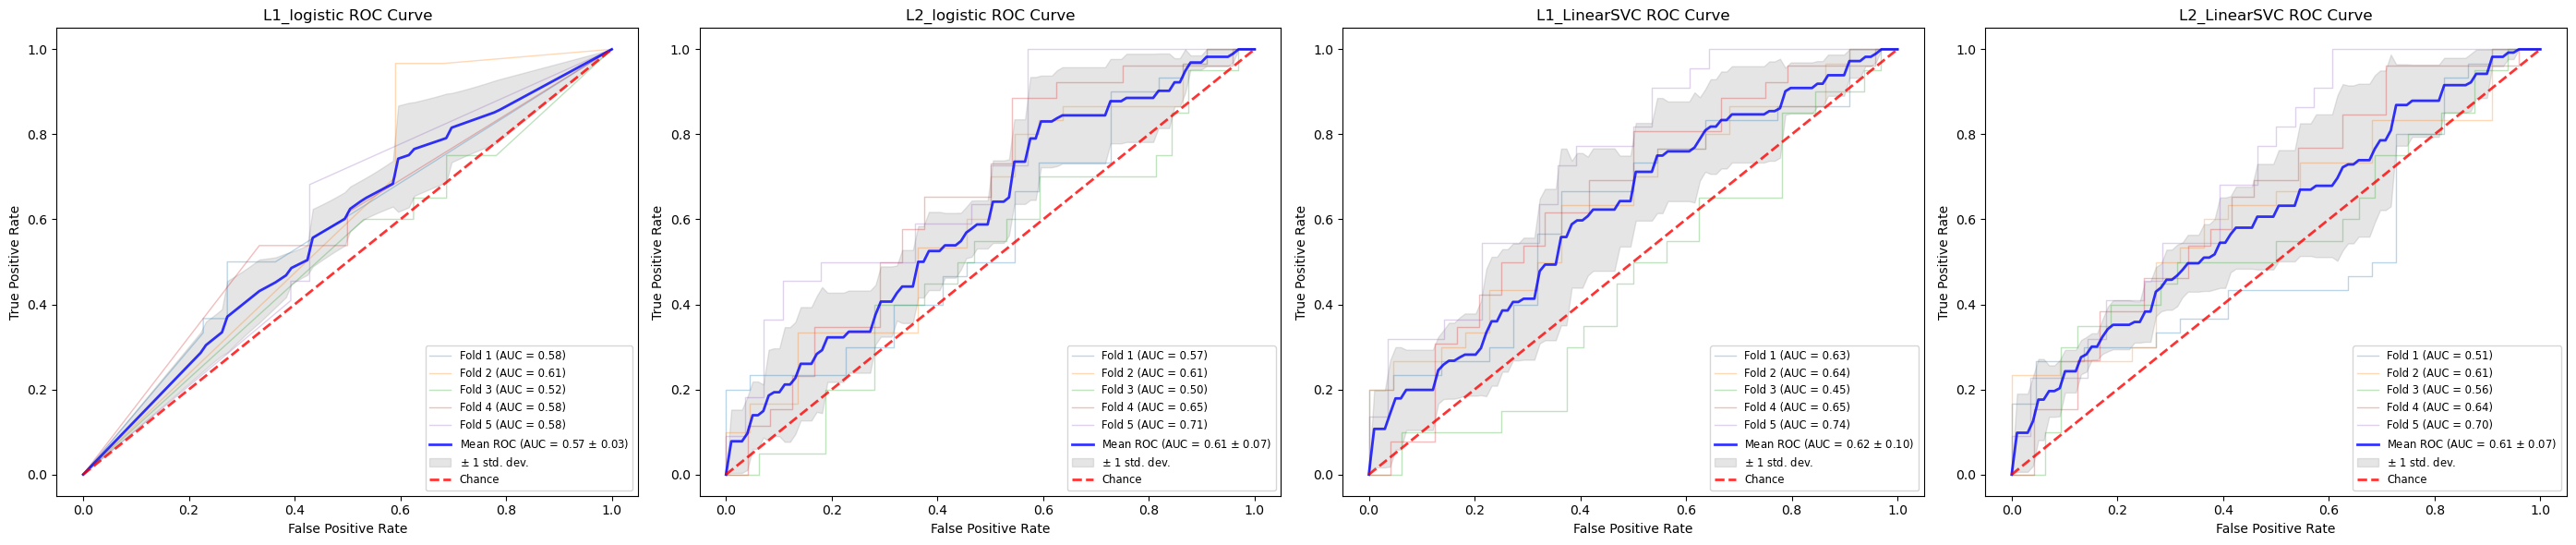

In [10]:
# Example for Alcohol Within-Group Evaluation
max_iter     = MAX_ITER_TRAINING
random_state = RANDOM_STATE_PIPELINE

# Define all four classifiers using extracted alphas (provide defaults if needed)
classifiers_alc = {
    'L1_logistic': SGDClassifier(loss='log_loss', penalty='l1',
                                 alpha=alc_best_alphas.get('log_loss_l1', DEFAULT_L1_LOGISTIC_ALPHA),
                                 random_state=random_state, max_iter=max_iter, class_weight='balanced'),
    'L2_logistic': SGDClassifier(loss='log_loss', penalty='l2',
                                 alpha=alc_best_alphas.get('log_loss_l2', DEFAULT_L2_LOGISTIC_ALPHA),
                                 random_state=random_state, max_iter=max_iter, class_weight='balanced'),
    'L1_LinearSVC': SGDClassifier(loss='hinge', penalty='l1',
                                  alpha=alc_best_alphas.get('hinge_l1', DEFAULT_L1_HINGE_ALPHA),
                                  random_state=random_state, max_iter=max_iter, class_weight='balanced'),
    'L2_LinearSVC': SGDClassifier(loss='hinge', penalty='l2',
                                  alpha=alc_best_alphas.get('hinge_l2', DEFAULT_L2_HINGE_ALPHA),
                                  random_state=random_state, max_iter=max_iter, class_weight='balanced')
}
print("\nDefined Classifiers for Alcohol Evaluation:")
for name, clf in classifiers_alc.items():
    print(f"  {name}: alpha={clf.alpha}")


# Instantiate evaluator
evaluator_alc = EvaluationPipeline(classifiers_alc)

# Run CV and plotting
print("\nRunning Alcohol Evaluation Pipeline...")
fig_alc, axes_alc, fitted_classifiers_alc = evaluator_alc.run_cv_and_plot(
    X_train=alc_X_train,
    y_train=alc_y_train,
    train_ids=alc_train_ids, # Need IDs for subject folds
    num_folds=CLASSIFICATION_CV_FOLDS,
    random_state_kfold=RANDOM_STATE_KFOlD
    # Keep calibrate_svc=False unless logistic models ONLY are used
)

# Save ROC figure (contains subplots for all 4 classifiers)
fig_alc.savefig(ALC_ROC_FIG, format='svg', dpi=1200, bbox_inches='tight')
print(f"\nSaved Alcohol ROC curve figure to {ALC_ROC_FIG}")
# plt.close(fig_alc) # Close figure

# Display metrics summary
alc_metrics_df = evaluator_alc.get_cv_metrics_summary()
print("\nAlcohol CV Metrics Summary:")
display(alc_metrics_df)

# Save the dictionary of final fitted models
evaluator_alc.save_fitted_models(ALCOHOL_MODEL_PKL)

# --- Test Set Evaluation (Optional - using one or all saved models) ---
if fitted_classifiers_alc:
    print("\n--- Alcohol Hold-Out Test Set Evaluation ---")
    # Load the saved models if needed, or use the returned dict
    # with open(ALCOHOL_MODEL_PKL, "rb") as f:
    #     loaded_models = pickle.load(f)

    for model_name, final_model in fitted_classifiers_alc.items():
         if final_model:
             preds_test_alc = final_model.predict(alc_X_test)
             test_acc_alc = np.mean(alc_y_test == preds_test_alc)
             test_cm_alc = confusion_matrix(alc_y_test, preds_test_alc)
             print(f"\nModel: {model_name}")
             print(f"  Test Accuracy: {test_acc_alc:.4f}")
             print(f"  Test Confusion Matrix:\n{test_cm_alc}")
         else:
             print(f"\nModel: {model_name} - Final model fitting failed.")

# Repeat for Cannabis Evaluation (original cell 16), using `can_best_alphas`
# Define `classifiers_can` using `can_best_alphas`
# evaluator_can = EvaluationPipeline(classifiers_can)
# fig_can, _, fitted_classifiers_can = evaluator_can.run_cv_and_plot(...)
# evaluator_can.save_fitted_models(CANNABIS_MODEL_PKL)
# ...

## CANNABIS

### GRID SEARCH

In [11]:
# Example for Cannabis Grid Search
param_grid_sgd = {'loss': ['hinge', 'log_loss'],
                  'penalty': ['l2', 'l1'],
                  'alpha': SGD_ALPHAS_GRID}

# Instantiate and run search
gs_runner_can = CustomGridSearch(
    param_grid=param_grid_sgd,
    random_state=RANDOM_STATE_GRIDSEARCH,
    max_iter=MAX_ITER_GRIDSEARCH
)
gs_runner_can.run_search(
    can_X_train,
    can_y_train,
    cv=GRIDSEARCH_CV_FOLDS,
    scoring='accuracy', # or 'roc_auc' etc.
    n_jobs=-1,
    verbose=1 # Add verbosity to see progress
)

# Get the dictionary of best alphas: {'log_loss_l1': 0.001, 'hinge_l2': 0.05, ...}
can_best_alphas = gs_runner_can.get_best_alphas()
print("\nBest Alphas Found (Cannabis):")
if can_best_alphas:
    for combo, alpha in can_best_alphas.items():
        print(f"  {combo}: {alpha}")
else:
    print("  No best alphas extracted (grid search may have failed).")

# Optional: Display full results DataFrame
# can_results_df = gs_runner_can.get_results_df()
# if can_results_df is not None:
#     print("\nFull Grid Search Results (Cannabis):")
#     display(can_results_df)

2025-04-20 23:31:43,555 - INFO - Running GridSearchCV for SGDClassifier...


Fitting 5 folds for each of 32 candidates, totalling 160 fits


2025-04-20 23:31:45,015 - INFO - GridSearchCV finished in 1.46 seconds.
2025-04-20 23:31:45,017 - INFO - Best alpha for hinge_l2: 0.10000 (score: 0.7276)
2025-04-20 23:31:45,018 - INFO - Best alpha for hinge_l1: 0.00001 (score: 0.7213)
2025-04-20 23:31:45,019 - INFO - Best alpha for log_loss_l2: 0.00000 (score: 0.7275)
2025-04-20 23:31:45,020 - INFO - Best alpha for log_loss_l1: 0.00000 (score: 0.7245)



Best Alphas Found (Cannabis):
  hinge_l2: 0.1
  hinge_l1: 1e-05
  log_loss_l2: 1e-06
  log_loss_l1: 1e-06


### OPTIMIZED MODELING

2025-04-20 23:31:45,048 - INFO - Running 5-fold CV for L1_logistic...



Defined Classifiers for Cannabis Evaluation:
  L1_logistic: alpha=1e-06
  L2_logistic: alpha=1e-06
  L1_LinearSVC: alpha=1e-05
  L2_LinearSVC: alpha=0.1

Running Cannabis Evaluation Pipeline...


2025-04-20 23:31:45,398 - INFO - L1_logistic: Mean CV Accuracy = 0.7695 +/- 0.0760
2025-04-20 23:31:45,399 - INFO - L1_logistic: Total Confusion Matrix (across folds):
[[ 73.  45.]
 [ 29. 176.]]
2025-04-20 23:31:45,470 - INFO - Running 5-fold CV for L2_logistic...
2025-04-20 23:31:45,620 - INFO - L2_logistic: Mean CV Accuracy = 0.7349 +/- 0.0576
2025-04-20 23:31:45,621 - INFO - L2_logistic: Total Confusion Matrix (across folds):
[[ 69.  49.]
 [ 36. 169.]]
2025-04-20 23:31:45,660 - INFO - Running 5-fold CV for L1_LinearSVC...
2025-04-20 23:31:45,992 - INFO - L1_LinearSVC: Mean CV Accuracy = 0.7481 +/- 0.0696
2025-04-20 23:31:45,992 - INFO - L1_LinearSVC: Total Confusion Matrix (across folds):
[[ 69.  49.]
 [ 32. 173.]]
2025-04-20 23:31:46,074 - INFO - Running 5-fold CV for L2_LinearSVC...
2025-04-20 23:31:46,509 - INFO - L2_LinearSVC: Mean CV Accuracy = 0.7541 +/- 0.0622
2025-04-20 23:31:46,509 - INFO - L2_LinearSVC: Total Confusion Matrix (across folds):
[[ 83.  35.]
 [ 44. 161.]]



Saved Cannabis ROC curve figure to /Users/kulkarnik/LocalProjects/multiclassifier_repo/reports/figures/can_classifier_roc_curve.svg

Cannabis CV Metrics Summary:


,Estimator,Mean CV Accuracy,Std CV Accuracy,Mean CV AUC,Std CV AUC,Total TP,Total FP,Total FN,Total TN,Overall Precision,Overall Recall (Sensitivity),Overall Specificity,Overall F1-Score
0,L1_logistic,0.7695,0.0760,0.7423,0.0871,176.0,45.0,29.0,73.0,0.7964,0.8585,0.6186,0.8263
1,L2_logistic,0.7349,0.0576,0.7202,0.0554,169.0,49.0,36.0,69.0,0.7752,0.8244,0.5847,0.7991
2,L1_LinearSVC,0.7481,0.0696,0.8046,0.0887,173.0,49.0,32.0,69.0,0.7793,0.8439,0.5847,0.8103
3,L2_LinearSVC,0.7541,0.0622,0.8123,0.0874,161.0,35.0,44.0,83.0,0.8214,0.7854,0.7034,0.8030


2025-04-20 23:31:46,876 - INFO - Saved final fitted models to /Users/kulkarnik/LocalProjects/multiclassifier_repo/models/cannabis_classifier_weights.pkl



--- Cannabis Hold-Out Test Set Evaluation ---

Model: L1_logistic
  Test Accuracy: 0.7955
  Test Confusion Matrix:
[[23 11]
 [ 7 47]]

Model: L2_logistic
  Test Accuracy: 0.8068
  Test Confusion Matrix:
[[26  8]
 [ 9 45]]

Model: L1_LinearSVC
  Test Accuracy: 0.7841
  Test Confusion Matrix:
[[25  9]
 [10 44]]

Model: L2_LinearSVC
  Test Accuracy: 0.7841
  Test Confusion Matrix:
[[26  8]
 [11 43]]


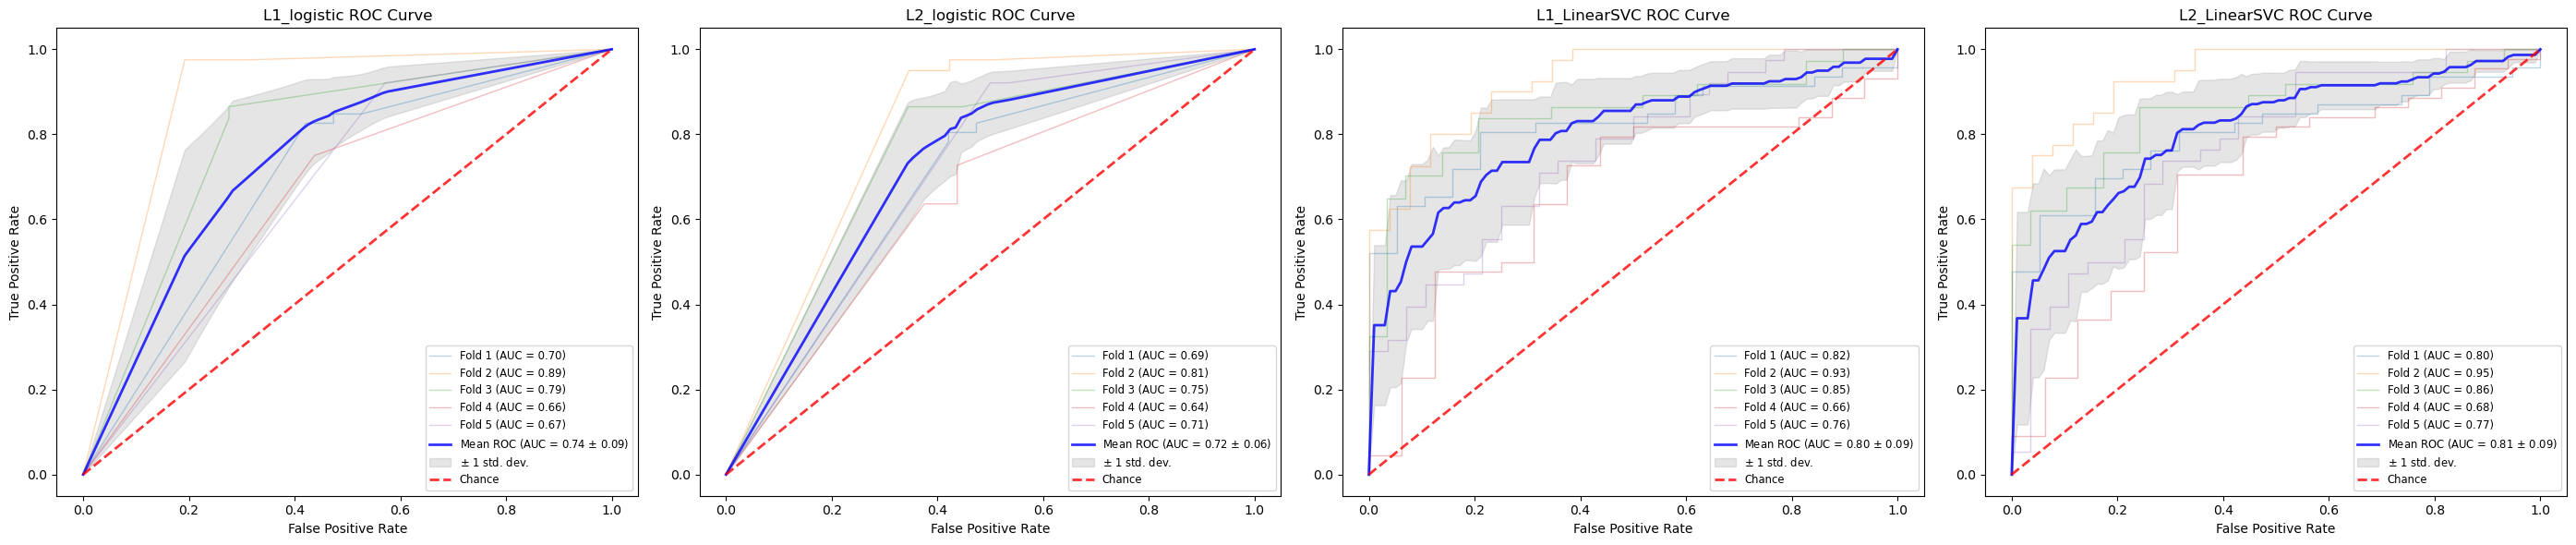

In [12]:
# Example for Cannabis Within-Group Evaluation
max_iter     = MAX_ITER_TRAINING
random_state = RANDOM_STATE_PIPELINE

# Define all four classifiers using extracted alphas (provide defaults if needed)
classifiers_can = {
    'L1_logistic': SGDClassifier(loss='log_loss', penalty='l1',
                                 alpha=can_best_alphas.get('log_loss_l1', DEFAULT_L1_LOGISTIC_ALPHA),
                                 random_state=random_state, max_iter=max_iter, class_weight='balanced'),
    'L2_logistic': SGDClassifier(loss='log_loss', penalty='l2',
                                 alpha=can_best_alphas.get('log_loss_l2', DEFAULT_L2_LOGISTIC_ALPHA),
                                 random_state=random_state, max_iter=max_iter, class_weight='balanced'),
    'L1_LinearSVC': SGDClassifier(loss='hinge', penalty='l1',
                                  alpha=can_best_alphas.get('hinge_l1', DEFAULT_L1_HINGE_ALPHA),
                                  random_state=random_state, max_iter=max_iter, class_weight='balanced'),
    'L2_LinearSVC': SGDClassifier(loss='hinge', penalty='l2',
                                  alpha=can_best_alphas.get('hinge_l2', DEFAULT_L2_HINGE_ALPHA),
                                  random_state=random_state, max_iter=max_iter, class_weight='balanced')
}
print("\nDefined Classifiers for Cannabis Evaluation:")
for name, clf in classifiers_can.items():
    print(f"  {name}: alpha={clf.alpha}")


# Instantiate evaluator
evaluator_can = EvaluationPipeline(classifiers_can)

# Run CV and plotting
print("\nRunning Cannabis Evaluation Pipeline...")
fig_can, axes_can, fitted_classifiers_can = evaluator_can.run_cv_and_plot(
    X_train=can_X_train,
    y_train=can_y_train,
    train_ids=can_train_ids, # Need IDs for subject folds
    num_folds=CLASSIFICATION_CV_FOLDS,
    random_state_kfold=RANDOM_STATE_KFOlD
    # Keep calibrate_svc=False unless logistic models ONLY are used
)

# Save ROC figure (contains subplots for all 4 classifiers)
fig_can.savefig(CAN_ROC_FIG, format='svg', dpi=1200, bbox_inches='tight')
print(f"\nSaved Cannabis ROC curve figure to {CAN_ROC_FIG}")
# plt.close(fig_can) # Close figure

# Display metrics summary
can_metrics_df = evaluator_can.get_cv_metrics_summary()
print("\nCannabis CV Metrics Summary:")
display(can_metrics_df)

# Save the dictionary of final fitted models
evaluator_can.save_fitted_models(CANNABIS_MODEL_PKL)

# --- Test Set Evaluation (Optional - using one or all saved models) ---
if fitted_classifiers_can:
    print("\n--- Cannabis Hold-Out Test Set Evaluation ---")
    # Load the saved models if needed, or use the returned dict
    # with open(Cannabis_MODEL_PKL, "rb") as f:
    #     loaded_models = pickle.load(f)

    for model_name, final_model in fitted_classifiers_can.items():
         if final_model:
             preds_test_can = final_model.predict(can_X_test)
             test_acc_can = np.mean(can_y_test == preds_test_can)
             test_cm_can = confusion_matrix(can_y_test, preds_test_can)
             print(f"\nModel: {model_name}")
             print(f"  Test Accuracy: {test_acc_can:.4f}")
             print(f"  Test Confusion Matrix:\n{test_cm_can}")
         else:
             print(f"\nModel: {model_name} - Final model fitting failed.")

# Repeat for Cannabis Evaluation (original cell 16), using `can_best_alphas`
# Define `classifiers_can` using `can_best_alphas`
# evaluator_can = EvaluationPipeline(classifiers_can)
# fig_can, _, fitted_classifiers_can = evaluator_can.run_cv_and_plot(...)
# evaluator_can.save_fitted_models(CANNABIS_MODEL_PKL)
# ...

## CROSS-CLASSIFICATION

2025-04-20 23:31:47,242 - INFO - Running 5-fold Cross-Evaluation for L1_logistic...



Defined Classifiers for Cross-Evaluation (based on Cannabis alphas):

Running Cross-Evaluation Pipeline (Train: Cannabis [Scaled], Eval: Alcohol [Scaled])...


2025-04-20 23:31:47,503 - INFO - L1_logistic: Mean Cross-Eval Accuracy = 0.5094 +/- 0.0159
2025-04-20 23:31:47,503 - INFO - L1_logistic: Total Cross-Eval Confusion Matrix (across folds):
[[399. 241.]
 [387. 253.]]
2025-04-20 23:31:47,559 - INFO - Running 5-fold Cross-Evaluation for L2_logistic...
2025-04-20 23:31:47,673 - INFO - L2_logistic: Mean Cross-Eval Accuracy = 0.5164 +/- 0.0223
2025-04-20 23:31:47,673 - INFO - L2_logistic: Total Cross-Eval Confusion Matrix (across folds):
[[339. 301.]
 [318. 322.]]
2025-04-20 23:31:47,704 - INFO - Running 5-fold Cross-Evaluation for L1_LinearSVC...
2025-04-20 23:31:47,928 - INFO - L1_LinearSVC: Mean Cross-Eval Accuracy = 0.5266 +/- 0.0161
2025-04-20 23:31:47,928 - INFO - L1_LinearSVC: Total Cross-Eval Confusion Matrix (across folds):
[[391. 249.]
 [357. 283.]]
2025-04-20 23:31:47,985 - INFO - Running 5-fold Cross-Evaluation for L2_LinearSVC...
2025-04-20 23:31:48,151 - INFO - L2_LinearSVC: Mean Cross-Eval Accuracy = 0.5344 +/- 0.0177
2025-04-20


Saved Cross-Evaluation ROC curve figure to /Users/kulkarnik/LocalProjects/multiclassifier_repo/reports/figures/cross_roc_train_can_eval_alc.svg

Cross-Evaluation (Train Can, Eval Alc) CV Metrics Summary:


,Estimator,Mean CV Accuracy,Std CV Accuracy,Mean CV AUC,Std CV AUC,Total TP,Total FP,Total FN,Total TN,Overall Precision,Overall Recall (Sensitivity),Overall Specificity,Overall F1-Score
0,L1_logistic,0.5094,0.0159,0.5090,0.0152,253.0,241.0,387.0,399.0,0.5121,0.3953,0.6234,0.4462
1,L2_logistic,0.5164,0.0223,0.5159,0.0208,322.0,301.0,318.0,339.0,0.5169,0.5031,0.5297,0.5099
2,L1_LinearSVC,0.5266,0.0161,0.5124,0.0270,283.0,249.0,357.0,391.0,0.5320,0.4422,0.6109,0.4829
3,L2_LinearSVC,0.5344,0.0177,0.5322,0.0193,404.0,360.0,236.0,280.0,0.5288,0.6312,0.4375,0.5755


2025-04-20 23:31:48,526 - INFO - Saved final fitted models to /Users/kulkarnik/LocalProjects/multiclassifier_repo/models/cross_model_train_can_eval_alc.pkl


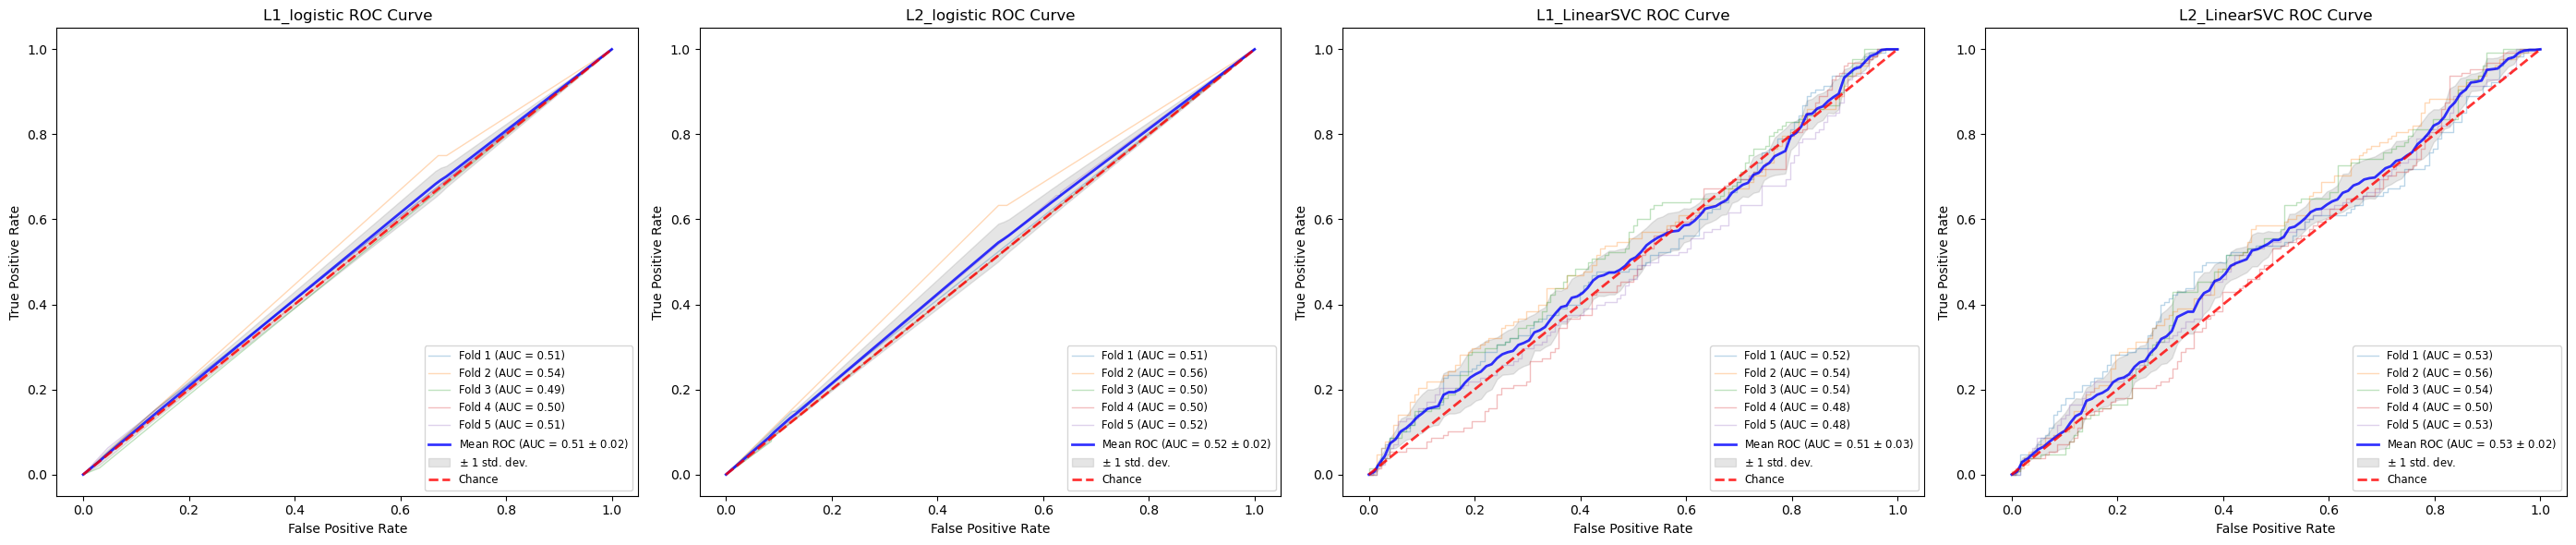

In [13]:
# Example for Cross-Group Evaluation (Train Cannabis, Eval Alcohol)
# Assume can_best_alphas holds best alphas found for Cannabis

max_iter     = MAX_ITER_TRAINING
random_state = RANDOM_STATE_CROSS # Or specific state for cross-eval

# Define classifiers using best CANNABIS alphas
classifiers_cross = {
    'L1_logistic': SGDClassifier(loss='log_loss', penalty='l1', alpha=can_best_alphas.get('log_loss_l1', DEFAULT_L1_LOGISTIC_ALPHA),
                                 random_state=random_state, max_iter=max_iter, class_weight='balanced'),
    'L2_logistic': SGDClassifier(loss='log_loss', penalty='l2', alpha=can_best_alphas.get('log_loss_l2', DEFAULT_L2_LOGISTIC_ALPHA),
                                 random_state=random_state, max_iter=max_iter, class_weight='balanced'),
    'L1_LinearSVC': SGDClassifier(loss='hinge', penalty='l1', alpha=can_best_alphas.get('hinge_l1', DEFAULT_L1_HINGE_ALPHA),
                                  random_state=random_state, max_iter=max_iter, class_weight='balanced'),
    'L2_LinearSVC': SGDClassifier(loss='hinge', penalty='l2', alpha=can_best_alphas.get('hinge_l2', DEFAULT_L2_HINGE_ALPHA),
                                  random_state=random_state, max_iter=max_iter, class_weight='balanced')
}
print("\nDefined Classifiers for Cross-Evaluation (based on Cannabis alphas):")
# (Optional print loop)

# Instantiate evaluator
cross_evaluator = CrossEvaluationPipeline(classifiers_cross)

# --- Scaling (Fit on Train [Can], Transform Train [Can] AND Eval [Alc]) ---
scaler_can_for_cross = StandardScaler()
can_X_train_scaled = scaler_can_for_cross.fit_transform(can_X_train)
# Use the SAME scaler fitted on Cannabis train to transform Alcohol train
alc_X_eval_scaled = scaler_can_for_cross.transform(alc_X_train)
# --- NOTE: Using alc_X_train as the evaluation set based on original cell 26 ---
# --- If you intend to evaluate on alc_X_test, use that instead:           ---
# alc_X_eval_scaled = scaler_can_for_cross.transform(alc_X_test)
# y_eval_data = alc_y_test
y_eval_data = alc_y_train # Corresponds to using alc_X_train as eval set

print("\nRunning Cross-Evaluation Pipeline (Train: Cannabis [Scaled], Eval: Alcohol [Scaled])...")
# Run cross-evaluation
fig_cross, axes_cross, fitted_classifiers_cross = cross_evaluator.run_cross_cv_and_plot(
    X_train=can_X_train_scaled,     # Scaled Cannabis Train
    y_train=can_y_train,
    X_eval=alc_X_eval_scaled,       # Scaled Alcohol Eval Data (using alc_X_train here)
    y_eval=y_eval_data,             # Alcohol Eval Labels (using alc_y_train here)
    num_folds=CLASSIFICATION_CV_FOLDS,
    random_state_kfold=RANDOM_STATE_KFOlD # Use consistent fold state if desired
)

# Save ROC figure
# Make filename specific to direction: Train_Eval
CROSS_CAN_ALC_ROC_FIG = FIGURE_DIR / "cross_roc_train_can_eval_alc.svg"
fig_cross.savefig(CROSS_CAN_ALC_ROC_FIG, format='svg', dpi=1200, bbox_inches='tight')
print(f"\nSaved Cross-Evaluation ROC curve figure to {CROSS_CAN_ALC_ROC_FIG}")
# plt.close(fig_cross)

# Display metrics summary
cross_metrics_df = cross_evaluator.get_cv_metrics_summary()
print("\nCross-Evaluation (Train Can, Eval Alc) CV Metrics Summary:")
display(cross_metrics_df)

# Save the final fitted models (trained on FULL SCALED CANNABIS data)
# Choose a descriptive name
CROSS_CAN_ALC_MODEL_PKL = MODELS_DIR / "cross_model_train_can_eval_alc.pkl"
cross_evaluator.save_fitted_models(CROSS_CAN_ALC_MODEL_PKL)

# Repeat the process for the other direction (Train Alc, Eval Can) if needed.

2025-04-20 23:31:48,909 - INFO - Running 5-fold Cross-Evaluation for L1_logistic...
2025-04-20 23:31:49,076 - INFO - L1_logistic: Mean Cross-Eval Accuracy = 0.5851 +/- 0.0510
2025-04-20 23:31:49,076 - INFO - L1_logistic: Total Cross-Eval Confusion Matrix (across folds):
[[143. 447.]
 [223. 802.]]



Defined Classifiers for Cross-Evaluation (based on Alcohol alphas):

Running Cross-Evaluation Pipeline (Train: Alcohol [Scaled], Eval: Cannabis [Scaled])...


2025-04-20 23:31:49,111 - INFO - Running 5-fold Cross-Evaluation for L2_logistic...
2025-04-20 23:31:49,256 - INFO - L2_logistic: Mean Cross-Eval Accuracy = 0.6291 +/- 0.0084
2025-04-20 23:31:49,256 - INFO - L2_logistic: Total Cross-Eval Confusion Matrix (across folds):
[[  11.  579.]
 [  20. 1005.]]
2025-04-20 23:31:49,299 - INFO - Running 5-fold Cross-Evaluation for L1_LinearSVC...
2025-04-20 23:31:49,472 - INFO - L1_LinearSVC: Mean Cross-Eval Accuracy = 0.6031 +/- 0.0492
2025-04-20 23:31:49,473 - INFO - L1_LinearSVC: Total Cross-Eval Confusion Matrix (across folds):
[[ 80. 510.]
 [131. 894.]]
2025-04-20 23:31:49,510 - INFO - Running 5-fold Cross-Evaluation for L2_LinearSVC...
2025-04-20 23:31:49,603 - INFO - L2_LinearSVC: Mean Cross-Eval Accuracy = 0.5845 +/- 0.0683
2025-04-20 23:31:49,603 - INFO - L2_LinearSVC: Total Cross-Eval Confusion Matrix (across folds):
[[145. 445.]
 [226. 799.]]



Saved Cross-Evaluation ROC curve figure to /Users/kulkarnik/LocalProjects/multiclassifier_repo/reports/figures/cross_roc_train_alc_eval_can.svg

Cross-Evaluation (Train Alc, Eval Can) CV Metrics Summary:


,Estimator,Mean CV Accuracy,Std CV Accuracy,Mean CV AUC,Std CV AUC,Total TP,Total FP,Total FN,Total TN,Overall Precision,Overall Recall (Sensitivity),Overall Specificity,Overall F1-Score
0,L1_logistic,0.5851,0.0510,0.5121,0.0165,802.0,447.0,223.0,143.0,0.6421,0.7824,0.2424,0.7054
1,L2_logistic,0.6291,0.0084,0.5070,0.0092,1005.0,579.0,20.0,11.0,0.6345,0.9805,0.0186,0.7704
2,L1_LinearSVC,0.6031,0.0492,0.5787,0.0521,894.0,510.0,131.0,80.0,0.6368,0.8722,0.1356,0.7361
3,L2_LinearSVC,0.5845,0.0683,0.5687,0.0287,799.0,445.0,226.0,145.0,0.6423,0.7795,0.2458,0.7043


2025-04-20 23:31:49,907 - INFO - Saved final fitted models to /Users/kulkarnik/LocalProjects/multiclassifier_repo/models/cross_model_train_alc_eval_can.pkl


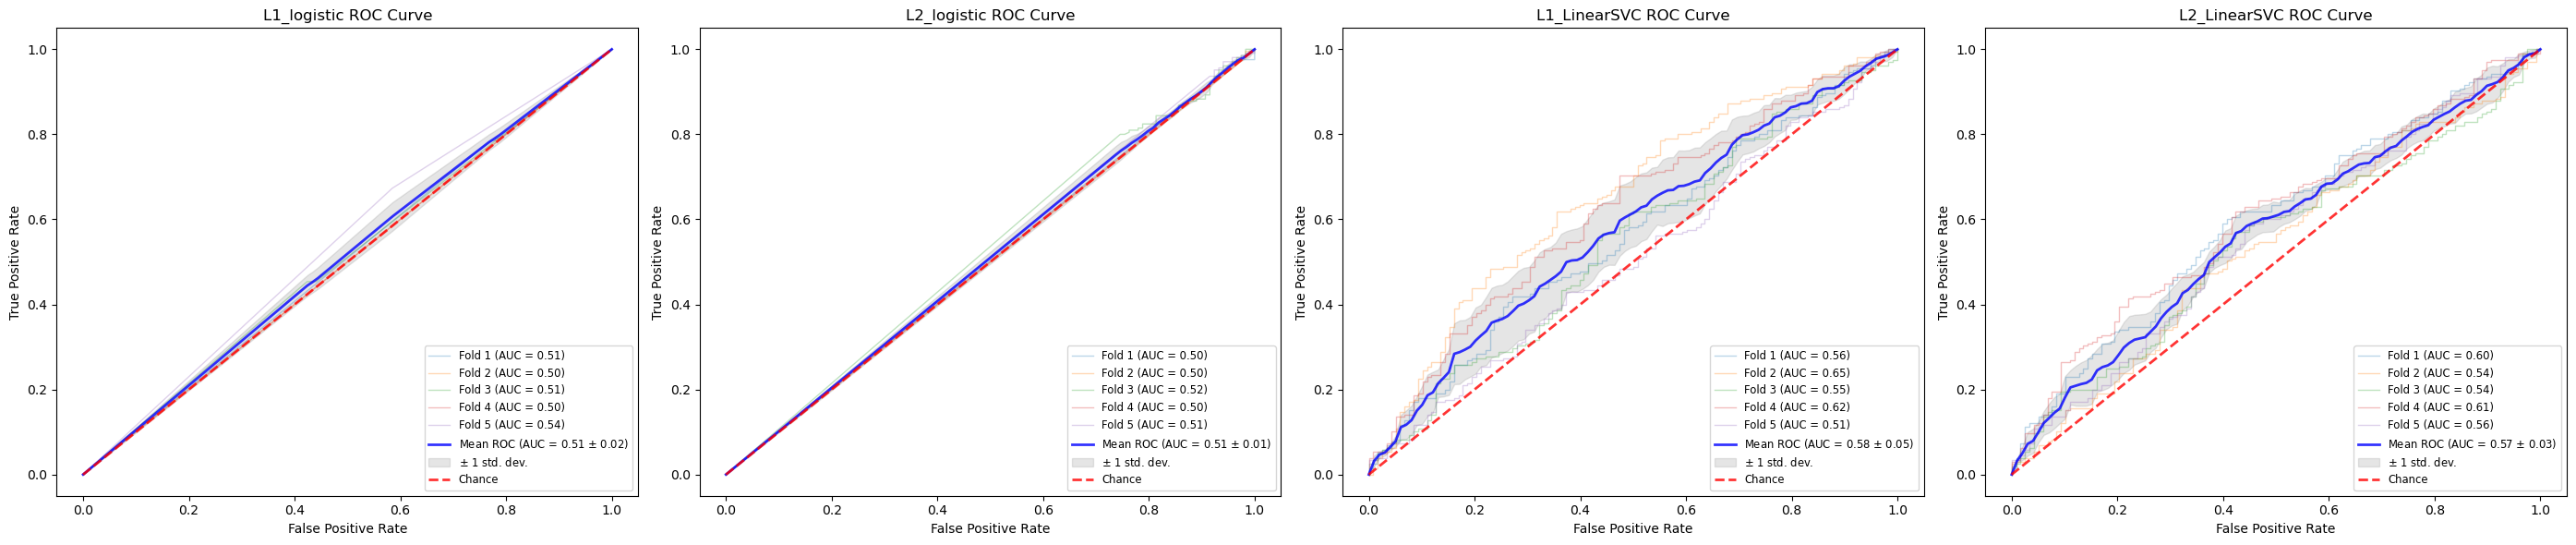

In [14]:
# Example for Cross-Group Evaluation (Train Alcohol, Eval Cannabis)
# Assume alc_best_alphas holds best alphas found for Alcohol

max_iter     = MAX_ITER_TRAINING
random_state = RANDOM_STATE_CROSS # Or specific state for cross-eval

# Define classifiers using best ALCOHOL alphas
classifiers_cross = {
    'L1_logistic': SGDClassifier(loss='log_loss', penalty='l1', alpha=alc_best_alphas.get('log_loss_l1', DEFAULT_L1_LOGISTIC_ALPHA),
                                 random_state=random_state, max_iter=max_iter, class_weight='balanced'),
    'L2_logistic': SGDClassifier(loss='log_loss', penalty='l2', alpha=alc_best_alphas.get('log_loss_l2', DEFAULT_L2_LOGISTIC_ALPHA),
                                 random_state=random_state, max_iter=max_iter, class_weight='balanced'),
    'L1_LinearSVC': SGDClassifier(loss='hinge', penalty='l1', alpha=alc_best_alphas.get('hinge_l1', DEFAULT_L1_HINGE_ALPHA),
                                  random_state=random_state, max_iter=max_iter, class_weight='balanced'),
    'L2_LinearSVC': SGDClassifier(loss='hinge', penalty='l2', alpha=alc_best_alphas.get('hinge_l2', DEFAULT_L2_HINGE_ALPHA),
                                  random_state=random_state, max_iter=max_iter, class_weight='balanced')
}
print("\nDefined Classifiers for Cross-Evaluation (based on Alcohol alphas):")
# (Optional print loop)

# Instantiate evaluator
cross_evaluator = CrossEvaluationPipeline(classifiers_cross)

# --- Scaling (Fit on Train [Alc], Transform Train [Alc] AND Eval [Can]) ---
scaler_alc_for_cross = StandardScaler()
alc_X_train_scaled = scaler_alc_for_cross.fit_transform(alc_X_train)
# Use the SAME scaler fitted on Alcohol train to transform Cannabis train
can_X_eval_scaled = scaler_alc_for_cross.transform(can_X_train)
y_eval_data = can_y_train # Corresponds to using can_X_train as eval set

print("\nRunning Cross-Evaluation Pipeline (Train: Alcohol [Scaled], Eval: Cannabis [Scaled])...")
# Run cross-evaluation
fig_cross, axes_cross, fitted_classifiers_cross = cross_evaluator.run_cross_cv_and_plot(
    X_train=alc_X_train_scaled,     # Scaled Cannabis Train
    y_train=alc_y_train,
    X_eval=can_X_eval_scaled,       # Scaled Alcohol Eval Data (using alc_X_train here)
    y_eval=y_eval_data,             # Alcohol Eval Labels (using alc_y_train here)
    num_folds=CLASSIFICATION_CV_FOLDS,
    random_state_kfold=RANDOM_STATE_KFOlD # Use consistent fold state if desired
)

# Save ROC figure
# Make filename specific to direction: Train_Eval
CROSS_ALC_CAN_ROC_FIG = FIGURE_DIR / "cross_roc_train_alc_eval_can.svg"
fig_cross.savefig(CROSS_ALC_CAN_ROC_FIG, format='svg', dpi=1200, bbox_inches='tight')
print(f"\nSaved Cross-Evaluation ROC curve figure to {CROSS_ALC_CAN_ROC_FIG}")
# plt.close(fig_cross)

# Display metrics summary
cross_metrics_df = cross_evaluator.get_cv_metrics_summary()
print("\nCross-Evaluation (Train Alc, Eval Can) CV Metrics Summary:")
display(cross_metrics_df)

# Save the final fitted models (trained on FULL SCALED ALCOHOL data)
# Choose a descriptive name
CROSS_ALC_CAN_MODEL_PKL = MODELS_DIR / "cross_model_train_alc_eval_can.pkl"
cross_evaluator.save_fitted_models(CROSS_ALC_CAN_MODEL_PKL)

## AGGREGATED

In [15]:
# === Aggregated Classification: Grid Search ===

print("\n" + "="*40)
print("Starting Aggregated Classification - Grid Search")
print("="*40 + "\n")

# --- Grid Search Setup ---
param_grid_sgd = {'loss': ['hinge', 'log_loss'],
                  'penalty': ['l2', 'l1'],
                  'alpha': SGD_ALPHAS_GRID} # Use alpha grid from config

# Instantiate and run search on aggregated training data (X_train, y_train)
# NOTE: Using the *unscaled* aggregated training data
gs_runner_agg = CustomGridSearch(
    param_grid=param_grid_sgd,
    random_state=RANDOM_STATE_GRIDSEARCH, # Use consistent state for grid search
    max_iter=MAX_ITER_GRIDSEARCH
)
print("Running GridSearchCV on Aggregated Data (Unscaled)...")
gs_runner_agg.run_search(
    X_train,  # <--- Using unscaled aggregated X_train
    y_train,
    cv=GRIDSEARCH_CV_FOLDS,
    scoring='accuracy', # or 'roc_auc' etc.
    n_jobs=-1,
    verbose=1
)

# --- Extract Best Alphas ---
agg_best_alphas = gs_runner_agg.get_best_alphas()
print("\nBest Alphas Found (Aggregated):")
if agg_best_alphas:
    for combo, alpha in agg_best_alphas.items():
        print(f"  {combo}: {alpha}")
else:
    print("  No best alphas extracted (grid search may have failed).")
    # Define fallbacks if needed downstream
    agg_best_alphas = { # Example fallbacks using defaults
        'log_loss_l1': DEFAULT_L1_LOGISTIC_ALPHA, 'log_loss_l2': DEFAULT_L2_LOGISTIC_ALPHA,
        'hinge_l1': DEFAULT_L1_HINGE_ALPHA, 'hinge_l2': DEFAULT_L2_HINGE_ALPHA,
    }
    print("  Using default alphas as fallback.")

# Optional: Display full results DataFrame
# agg_results_df = gs_runner_agg.get_results_df()
# if agg_results_df is not None:
#     print("\nFull Grid Search Results (Aggregated):")
#     display(agg_results_df)

print("\n" + "="*40)
print("Finished Aggregated Grid Search")
print("="*40 + "\n")

2025-04-20 23:31:50,277 - INFO - Running GridSearchCV for SGDClassifier...



Starting Aggregated Classification - Grid Search

Running GridSearchCV on Aggregated Data (Unscaled)...
Fitting 5 folds for each of 32 candidates, totalling 160 fits


2025-04-20 23:31:53,295 - INFO - GridSearchCV finished in 3.02 seconds.
2025-04-20 23:31:53,297 - INFO - Best alpha for hinge_l2: 0.01000 (score: 0.5717)
2025-04-20 23:31:53,298 - INFO - Best alpha for hinge_l1: 0.00000 (score: 0.5545)
2025-04-20 23:31:53,299 - INFO - Best alpha for log_loss_l2: 0.00100 (score: 0.5667)
2025-04-20 23:31:53,300 - INFO - Best alpha for log_loss_l1: 0.00001 (score: 0.5701)



Best Alphas Found (Aggregated):
  hinge_l2: 0.01
  hinge_l1: 1e-06
  log_loss_l2: 0.001
  log_loss_l1: 1e-05

Finished Aggregated Grid Search



2025-04-20 23:31:53,335 - INFO - Running 5-fold CV for L1_logistic...



Starting Aggregated Classification - Evaluation (No Scaling)

Defined Classifiers for Aggregated Evaluation (using best alphas):
  L1_logistic: alpha=1e-05
  L2_logistic: alpha=0.001
  L1_LinearSVC: alpha=1e-06
  L2_LinearSVC: alpha=0.01

Running Aggregated Evaluation Pipeline (Unscaled Data)...


2025-04-20 23:31:53,916 - INFO - L1_logistic: Mean CV Accuracy = 0.6628 +/- 0.0252
2025-04-20 23:31:53,916 - INFO - L1_logistic: Total Confusion Matrix (across folds):
[[142. 104.]
 [ 91. 242.]]
2025-04-20 23:31:54,046 - INFO - Running 5-fold CV for L2_logistic...
2025-04-20 23:31:54,653 - INFO - L2_logistic: Mean CV Accuracy = 0.6753 +/- 0.0437
2025-04-20 23:31:54,653 - INFO - L2_logistic: Total Confusion Matrix (across folds):
[[152.  94.]
 [ 94. 239.]]
2025-04-20 23:31:54,789 - INFO - Running 5-fold CV for L1_LinearSVC...
2025-04-20 23:31:55,338 - INFO - L1_LinearSVC: Mean CV Accuracy = 0.6736 +/- 0.0172
2025-04-20 23:31:55,339 - INFO - L1_LinearSVC: Total Confusion Matrix (across folds):
[[148.  98.]
 [ 91. 242.]]
2025-04-20 23:31:55,458 - INFO - Running 5-fold CV for L2_LinearSVC...
2025-04-20 23:31:55,786 - INFO - L2_LinearSVC: Mean CV Accuracy = 0.6770 +/- 0.0321
2025-04-20 23:31:55,787 - INFO - L2_LinearSVC: Total Confusion Matrix (across folds):
[[143. 103.]
 [ 84. 249.]]
2025


Saved Aggregated ROC curve figure to /Users/kulkarnik/LocalProjects/multiclassifier_repo/reports/figures/aggregated_classifier_roc_curve.svg

Aggregated CV Metrics Summary (Unscaled Data):


,Estimator,Mean CV Accuracy,Std CV Accuracy,Mean CV AUC,Std CV AUC,Total TP,Total FP,Total FN,Total TN,Overall Precision,Overall Recall (Sensitivity),Overall Specificity,Overall F1-Score
0,L1_logistic,0.6628,0.0252,0.6579,0.0233,242.0,104.0,91.0,142.0,0.6994,0.7267,0.5772,0.7128
1,L2_logistic,0.6753,0.0437,0.7440,0.0450,239.0,94.0,94.0,152.0,0.7177,0.7177,0.6179,0.7177
2,L1_LinearSVC,0.6736,0.0172,0.7381,0.0423,242.0,98.0,91.0,148.0,0.7118,0.7267,0.6016,0.7192
3,L2_LinearSVC,0.6770,0.0321,0.7514,0.0456,249.0,103.0,84.0,143.0,0.7074,0.7477,0.5813,0.7270



--- Aggregated Hold-Out Test Set Evaluation (Unscaled Data) ---

Model: L1_logistic
  Test Accuracy: 0.7237
  Test Confusion Matrix:
[[45 21]
 [21 65]]

Model: L2_logistic
  Test Accuracy: 0.7368
  Test Confusion Matrix:
[[47 19]
 [21 65]]

Model: L1_LinearSVC
  Test Accuracy: 0.7303
  Test Confusion Matrix:
[[51 15]
 [26 60]]

Model: L2_LinearSVC
  Test Accuracy: 0.7171
  Test Confusion Matrix:
[[48 18]
 [25 61]]

Finished Aggregated Classification (No Scaling)



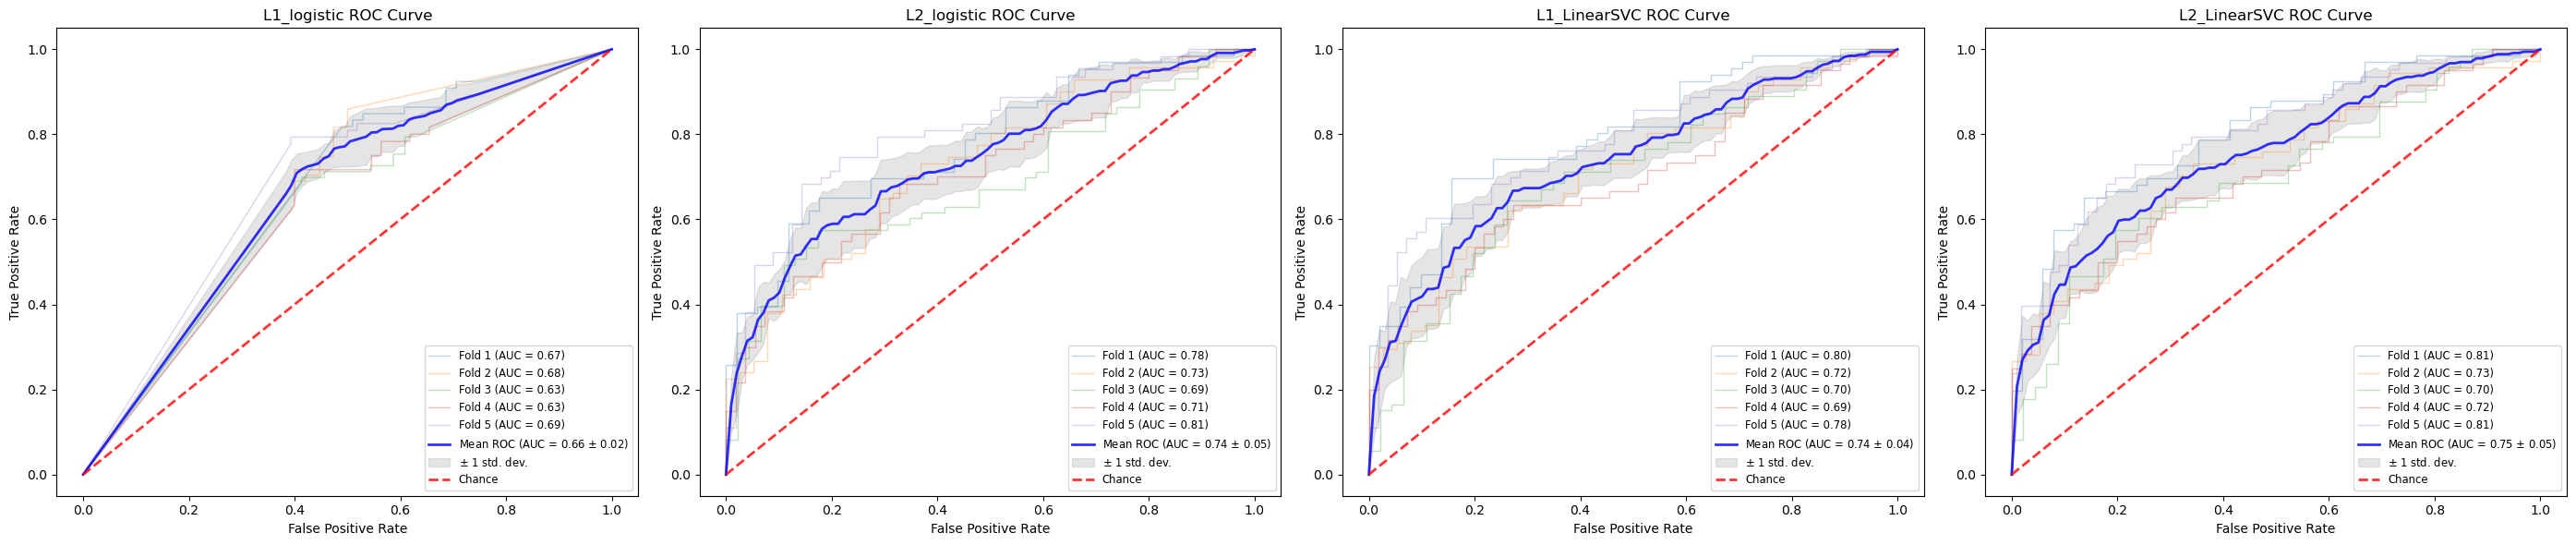

In [16]:
# === Aggregated Classification: Evaluation (No Scaling) ===

print("\n" + "="*40)
print("Starting Aggregated Classification - Evaluation (No Scaling)")
print("="*40 + "\n")

# Check if agg_best_alphas exists from the previous cell
if 'agg_best_alphas' not in locals():
    print("Error: Aggregated grid search cell must be run first to define 'agg_best_alphas'.")
    # Optionally define fallbacks again here if you want this cell to be runnable independently after a restart
    # agg_best_alphas = { ... defaults ... }
    raise NameError("Variable 'agg_best_alphas' not defined.")


# --- Define Classifiers using Best Alphas from Grid Search ---
max_iter     = MAX_ITER_TRAINING
random_state = RANDOM_STATE_AGG # Use specific random state for evaluation pipeline

classifiers_agg = {
    'L1_logistic': SGDClassifier(loss='log_loss', penalty='l1',
                                 alpha=agg_best_alphas.get('log_loss_l1', DEFAULT_L1_LOGISTIC_ALPHA),
                                 random_state=random_state, max_iter=max_iter, class_weight='balanced'),
    'L2_logistic': SGDClassifier(loss='log_loss', penalty='l2',
                                 alpha=agg_best_alphas.get('log_loss_l2', DEFAULT_L2_LOGISTIC_ALPHA),
                                 random_state=random_state, max_iter=max_iter, class_weight='balanced'),
    'L1_LinearSVC': SGDClassifier(loss='hinge', penalty='l1',
                                  alpha=agg_best_alphas.get('hinge_l1', DEFAULT_L1_HINGE_ALPHA),
                                  random_state=random_state, max_iter=max_iter, class_weight='balanced'),
    'L2_LinearSVC': SGDClassifier(loss='hinge', penalty='l2',
                                  alpha=agg_best_alphas.get('hinge_l2', DEFAULT_L2_HINGE_ALPHA),
                                  random_state=random_state, max_iter=max_iter, class_weight='balanced')
}
print("Defined Classifiers for Aggregated Evaluation (using best alphas):")
for name, clf in classifiers_agg.items():
    print(f"  {name}: alpha={clf.alpha}")


# --- Instantiate and Run Evaluation Pipeline (NO SCALING) ---
evaluator_agg = EvaluationPipeline(classifiers_agg)

print("\nRunning Aggregated Evaluation Pipeline (Unscaled Data)...")
# Evaluate on the UNscaled aggregated training data using subject-aware KFold CV
fig_agg, axes_agg, fitted_classifiers_agg = evaluator_agg.run_cv_and_plot(
    X_train=X_train,           # <--- Using unscaled X_train
    y_train=y_train,
    train_ids=train_ids,       # Pass the combined subject IDs
    num_folds=CLASSIFICATION_CV_FOLDS,
    random_state_kfold=RANDOM_STATE_KFOlD
)

# --- Save Outputs ---
# Save ROC figure
fig_agg.savefig(AGG_ROC_FIG, format='svg', dpi=1200, bbox_inches='tight')
print(f"\nSaved Aggregated ROC curve figure to {AGG_ROC_FIG}")
# plt.close(fig_agg)

# Save the dictionary of final fitted models (trained on full UNscaled X_train)
evaluator_agg.save_fitted_models(AGGREGATED_MODEL_PKL)

# --- Display Metrics ---
agg_metrics_df = evaluator_agg.get_cv_metrics_summary()
print("\nAggregated CV Metrics Summary (Unscaled Data):")
display(agg_metrics_df)

# --- Test Set Evaluation (Original Cell 32 logic - NO SCALING) ---
print("\n--- Aggregated Hold-Out Test Set Evaluation (Unscaled Data) ---")
if fitted_classifiers_agg:
    # Evaluate each fitted model on the UNscaled test set (X_test)
    for model_name, final_model in fitted_classifiers_agg.items():
         if final_model:
             preds_test_agg = final_model.predict(X_test) # <--- Use unscaled X_test
             test_acc_agg = np.mean(y_test == preds_test_agg)
             test_cm_agg = confusion_matrix(y_test, preds_test_agg)
             print(f"\nModel: {model_name}")
             print(f"  Test Accuracy: {test_acc_agg:.4f}")
             print(f"  Test Confusion Matrix:\n{test_cm_agg}")
         else:
             print(f"\nModel: {model_name} - Final model fitting failed.")
else:
    print("No final aggregated models were fitted successfully for test evaluation.")

print("\n" + "="*40)
print("Finished Aggregated Classification (No Scaling)")
print("="*40 + "\n")

## 3-WAY CLASSIFICATION

In [17]:
# === 3-Way Classification: Data Preparation ===

print("\n" + "="*40)
print("Starting 3-Way Classification - Data Preparation")
print("="*40 + "\n")

# Define class labels
CANNABIS_LABEL = 1
ALCOHOL_LABEL = 2 # From config: ALCOHOL_CLASS_LABEL_MULTI

# --- !! Revisit Label Creation Logic !! ---
# Create combined training data (NO SCALING)
three_X_train = np.concatenate([alc_X_train, can_X_train], axis=0)
# Placeholder logic from original notebook - VERIFY THIS MATCHES YOUR DATA SEMANTICS
three_y_train = np.concatenate([alc_y_train * ALCOHOL_LABEL, can_y_train * CANNABIS_LABEL], axis=0)
unique_labels_train, counts_train = np.unique(three_y_train, return_counts=True)
print(f"Combined Training Labels (Unique): {unique_labels_train}")
print(f"Combined Training Label Counts: {counts_train}")
if len(unique_labels_train) < 3: print("Warning: Fewer than 3 classes found in combined training data.")

# Create combined test data (NO SCALING)
if not all(arr.size > 0 for arr in [alc_X_test, can_X_test, alc_y_test, can_y_test]):
     print("Warning: Alcohol or Cannabis test data is empty.")
     three_X_test = np.array([]).reshape(0, three_X_train.shape[1])
     three_y_test = np.array([])
else:
    three_X_test = np.concatenate([alc_X_test, can_X_test], axis=0)
    # Apply same label logic as for training data - VERIFY THIS
    three_y_test = np.concatenate([alc_y_test * ALCOHOL_LABEL, can_y_test * CANNABIS_LABEL], axis=0)
    unique_labels_test, counts_test = np.unique(three_y_test, return_counts=True)
    print(f"Combined Test Labels (Unique): {unique_labels_test}")
    print(f"Combined Test Label Counts: {counts_test}")

print("\nCombined Data Shapes (Unscaled):")
print(f"  Train: X={three_X_train.shape}, y={three_y_train.shape}")
print(f"  Test:  X={three_X_test.shape}, y={three_y_test.shape}")

print("\n" + "="*40)
print("Finished 3-Way Data Preparation")
print("="*40 + "\n")


Starting 3-Way Classification - Data Preparation

Combined Training Labels (Unique): [0. 1. 2.]
Combined Training Label Counts: [246 205 128]
Combined Test Labels (Unique): [0. 1. 2.]
Combined Test Label Counts: [66 54 32]

Combined Data Shapes (Unscaled):
  Train: X=(579, 4950), y=(579,)
  Test:  X=(152, 4950), y=(152,)

Finished 3-Way Data Preparation



In [18]:
# === 3-Way Classification: Grid Search (OneVsRest Strategy - Per Variant) ===

print("\n" + "="*40)
print("Starting 3-Way Grid Search (OneVsRest - Per Variant)")
print("="*40 + "\n")

ovr_best_alphas = {} # Dictionary to store best alpha for each combo
sgd_variants = [
    {'loss': 'log_loss', 'penalty': 'l1', 'name': 'L1_logistic'},
    {'loss': 'log_loss', 'penalty': 'l2', 'name': 'L2_logistic'},
    {'loss': 'hinge',    'penalty': 'l1', 'name': 'L1_LinearSVC'},
    {'loss': 'hinge',    'penalty': 'l2', 'name': 'L2_LinearSVC'}
]

for variant in sgd_variants:
    combo_name = f"OVR_{variant['name']}"
    print(f"--- Running Grid Search for {combo_name} ---")

    # Define base SGD with this variant's fixed loss/penalty
    base_sgd = SGDClassifier(
        loss=variant['loss'],
        penalty=variant['penalty'],
        random_state=RANDOM_STATE_GRIDSEARCH,
        max_iter=MAX_ITER_GRIDSEARCH,
        class_weight='balanced'
    )
    ovr_clf = OneVsRestClassifier(base_sgd)

    # Grid search ONLY over alpha for this specific base estimator
    param_grid_alpha_only = {'estimator__alpha': SGD_ALPHAS_GRID}

    grid_search_ovr_variant = GridSearchCV(
        estimator=ovr_clf,
        param_grid=param_grid_alpha_only,
        cv=GRIDSEARCH_CV_FOLDS,
        scoring='accuracy',
        n_jobs=-1,
        verbose=0 # Reduce verbosity inside loop
    )

    try:
        grid_search_ovr_variant.fit(three_X_train, three_y_train) # Use unscaled 3-class data
        best_alpha = grid_search_ovr_variant.best_params_['estimator__alpha']
        best_score = grid_search_ovr_variant.best_score_
        ovr_best_alphas[variant['name']] = best_alpha # Store using base name ('L1_logistic')
        print(f"  Best Alpha: {best_alpha:.6f} (Accuracy: {best_score:.4f})")
    except Exception as e:
        print(f"  Grid search failed for {combo_name}: {e}")
        # Provide a default alpha as fallback if needed
        ovr_best_alphas[variant['name']] = DEFAULT_L1_LOGISTIC_ALPHA # Example default

print("\nBest Alphas found for OVR variants:")
print(ovr_best_alphas)

print("\n" + "="*40)
print("Finished 3-Way Grid Search (OneVsRest - Per Variant)")
print("="*40 + "\n")


Starting 3-Way Grid Search (OneVsRest - Per Variant)

--- Running Grid Search for OVR_L1_logistic ---
  Best Alpha: 0.000100 (Accuracy: 0.5976)
--- Running Grid Search for OVR_L2_logistic ---
  Best Alpha: 0.000001 (Accuracy: 0.5959)
--- Running Grid Search for OVR_L1_LinearSVC ---
  Best Alpha: 0.000010 (Accuracy: 0.5873)
--- Running Grid Search for OVR_L2_LinearSVC ---
  Best Alpha: 0.001000 (Accuracy: 0.6097)

Best Alphas found for OVR variants:
{'L1_logistic': 0.0001, 'L2_logistic': 1e-06, 'L1_LinearSVC': 1e-05, 'L2_LinearSVC': 0.001}

Finished 3-Way Grid Search (OneVsRest - Per Variant)



2025-04-20 23:32:31,171 - INFO - Running 5-fold Stratified CV for OVR_L1_logistic...



Starting 3-Way Evaluation (OneVsRest - Using Best Alphas)

Defined final OVR classifiers:
  OVR_L1_logistic
  OVR_L2_logistic
  OVR_L1_LinearSVC
  OVR_L2_LinearSVC

Running Multi-Class Evaluation Pipeline (OVR)...


2025-04-20 23:32:33,017 - INFO -   OVR_L1_logistic CV finished. Mean Accuracy: 0.8118 +/- 0.0306
2025-04-20 23:32:33,484 - INFO -   Fitted final model for OVR_L1_logistic on full training data.
2025-04-20 23:32:33,484 - INFO - Running 5-fold Stratified CV for OVR_L2_logistic...
2025-04-20 23:32:34,220 - INFO -   OVR_L2_logistic CV finished. Mean Accuracy: 0.8032 +/- 0.0301
2025-04-20 23:32:34,437 - INFO -   Fitted final model for OVR_L2_logistic on full training data.
2025-04-20 23:32:34,438 - INFO - Running 5-fold Stratified CV for OVR_L1_LinearSVC...
2025-04-20 23:32:35,869 - INFO -   OVR_L1_LinearSVC CV finished. Mean Accuracy: 0.8153 +/- 0.0277
2025-04-20 23:32:36,209 - INFO -   Fitted final model for OVR_L1_LinearSVC on full training data.
2025-04-20 23:32:36,210 - INFO - Running 5-fold Stratified CV for OVR_L2_LinearSVC...
2025-04-20 23:32:36,975 - INFO -   OVR_L2_LinearSVC CV finished. Mean Accuracy: 0.8083 +/- 0.0362
2025-04-20 23:32:37,142 - INFO -   Fitted final model for OVR


OVR Cross-Validation Metrics Summary:


,Estimator,Mean CV Accuracy,Std CV Accuracy
0,OVR_L1_logistic,0.8118,0.0306
1,OVR_L2_logistic,0.8032,0.0301
2,OVR_L1_LinearSVC,0.8153,0.0277
3,OVR_L2_LinearSVC,0.8083,0.0362



--- 3-Way Hold-Out Test Set Evaluation (OVR) ---

--- Evaluating: OVR_L1_logistic ---
  Test Accuracy: 0.7500
  Test Classification Report:
              precision    recall  f1-score   support

          HC       0.69      0.77      0.73        66
    Cannabis       0.83      0.83      0.83        54
     Alcohol       0.75      0.56      0.64        32

    accuracy                           0.75       152
   macro avg       0.76      0.72      0.73       152
weighted avg       0.75      0.75      0.75       152


--- Evaluating: OVR_L2_logistic ---
  Test Accuracy: 0.7829
  Test Classification Report:
              precision    recall  f1-score   support

          HC       0.74      0.77      0.76        66
    Cannabis       0.84      0.89      0.86        54
     Alcohol       0.77      0.62      0.69        32

    accuracy                           0.78       152
   macro avg       0.78      0.76      0.77       152
weighted avg       0.78      0.78      0.78       152


--- E

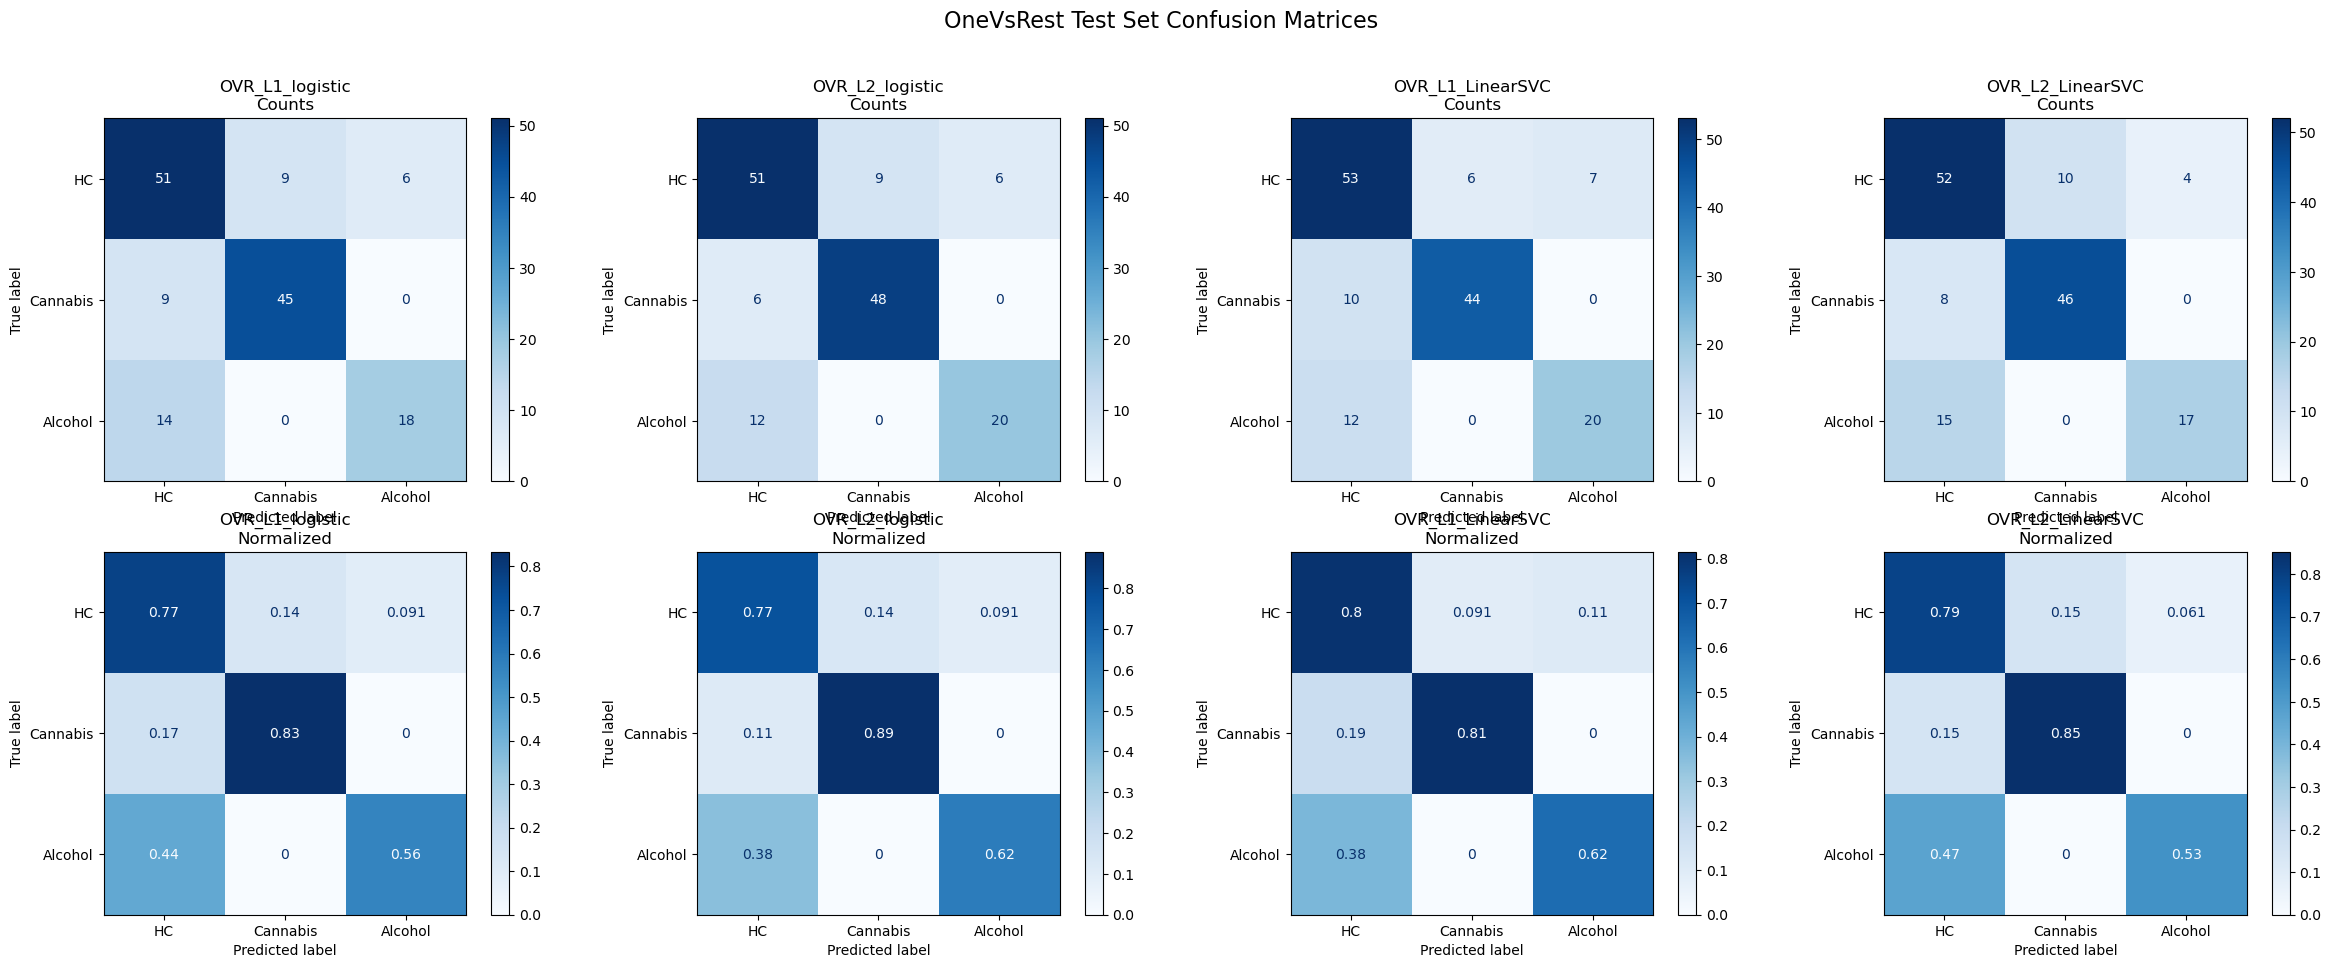


Finished 3-Way Evaluation (OneVsRest)



In [19]:
# === 3-Way Classification: Evaluation (OneVsRest Strategy - No Scaling) ===

print("\n" + "="*40)
print("Starting 3-Way Evaluation (OneVsRest - Using Best Alphas)")
print("="*40 + "\n")

# Check if best alphas exist from previous cell
if 'ovr_best_alphas' not in locals() or not ovr_best_alphas:
    raise NameError("OVR Grid search cell must be run first to define 'ovr_best_alphas'.")

# --- Define the 4 Final OVR Classifiers with their Best Alphas ---
classifiers_ovr = {}
for variant in sgd_variants:
    variant_name = variant['name']
    best_alpha = ovr_best_alphas.get(variant_name)
    if best_alpha is None:
         print(f"Warning: No best alpha found for OVR {variant_name}, skipping evaluation.")
         continue

    final_sgd = SGDClassifier(
        loss=variant['loss'],
        penalty=variant['penalty'],
        alpha=best_alpha, # Use the best alpha found
        random_state=RANDOM_STATE_MULTICLASS,
        max_iter=MAX_ITER_TRAINING,
        class_weight='balanced'
    )
    classifiers_ovr[f"OVR_{variant_name}"] = OneVsRestClassifier(final_sgd)

print("Defined final OVR classifiers:")
for name in classifiers_ovr: print(f"  {name}")

# --- Instantiate and Run MultiClassEvaluator ---
if not classifiers_ovr:
     print("No valid OVR classifiers defined, skipping evaluation.")
else:
    multi_evaluator_ovr = MultiClassEvaluator(classifiers_ovr)

    print("\nRunning Multi-Class Evaluation Pipeline (OVR)...")
    cv_results_ovr, fitted_ovr_models_dict = multi_evaluator_ovr.evaluate_cv(
        X_train=three_X_train, # Unscaled 3-class train data
        y_train=three_y_train,
        n_splits=CLASSIFICATION_CV_FOLDS,
        random_state_kfold=RANDOM_STATE_KFOlD
    )

    # --- Save Final Models ---
    multi_evaluator_ovr.save_models(THREECLASS_ONEVREST_PKL) # Save dict of models

    # --- Display CV Metrics ---
    ovr_metrics_df = multi_evaluator_ovr.get_cv_metrics_summary()
    print("\nOVR Cross-Validation Metrics Summary:")
    display(ovr_metrics_df)


    # --- Test Set Evaluation & Plotting ---
    print("\n--- 3-Way Hold-Out Test Set Evaluation (OVR) ---")
    if fitted_ovr_models_dict and three_X_test.size > 0:
        # Create figure for confusion matrices (subplots)
        n_models_ovr = len(fitted_ovr_models_dict)
        fig_cm_ovr, axes_cm_ovr = plt.subplots(2, n_models_ovr, figsize=(6 * n_models_ovr, 10), squeeze=False)

        col_idx = 0
        for model_name, fitted_model in fitted_ovr_models_dict.items():
            print(f"\n--- Evaluating: {model_name} ---")
            if fitted_model:
                try:
                    preds_test = fitted_model.predict(three_X_test) # Use unscaled test data
                    test_acc = accuracy_score(three_y_test, preds_test)
                    print(f"  Test Accuracy: {test_acc:.4f}")

                    # Classification Report
                    target_names = MULTICLASS_LABELS if 'MULTICLASS_LABELS' in locals() else [f'Class {i}' for i in np.unique(three_y_train)]
                    print("  Test Classification Report:")
                    print(classification_report(three_y_test, preds_test, target_names=target_names, zero_division=0))

                    # Plot Confusion Matrix (Counts)
                    ConfusionMatrixDisplay.from_predictions(
                        three_y_test, preds_test, ax=axes_cm_ovr[0, col_idx],
                        display_labels=target_names, cmap=plt.cm.Blues
                    )
                    axes_cm_ovr[0, col_idx].set_title(f'{model_name}\nCounts')

                    # Plot Confusion Matrix (Normalized)
                    ConfusionMatrixDisplay.from_predictions(
                        three_y_test, preds_test, ax=axes_cm_ovr[1, col_idx],
                        display_labels=target_names, cmap=plt.cm.Blues, normalize='true'
                    )
                    axes_cm_ovr[1, col_idx].set_title(f'{model_name}\nNormalized')
                    col_idx += 1

                except Exception as e:
                    print(f"  Error during test set evaluation for {model_name}: {e}")
                    # Optionally clear the axes for this model if plotting fails
                    axes_cm_ovr[0, col_idx].set_title(f'{model_name}\nEval Error')
                    axes_cm_ovr[1, col_idx].set_title(f'{model_name}\nEval Error')
                    col_idx +=1 # Move to next column even if error occurred
            else:
                 print(f"  Skipping evaluation (model fitting failed).")
                 axes_cm_ovr[0, col_idx].set_title(f'{model_name}\nNo Model')
                 axes_cm_ovr[1, col_idx].set_title(f'{model_name}\nNo Model')
                 col_idx +=1


        fig_cm_ovr.suptitle('OneVsRest Test Set Confusion Matrices', fontsize=16)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        fig_cm_ovr.savefig(MULTICLASS_OVR_CM_FIG, format='svg', dpi=1200, bbox_inches='tight')
        print(f"\nSaved OVR Confusion Matrix plot to {MULTICLASS_OVR_CM_FIG}")
        plt.show()

    elif not fitted_ovr_models_dict:
        print("No final OVR models were fitted successfully.")
    else: # Test data empty
        print("Test data is empty. Cannot evaluate on test set.")

print("\n" + "="*40)
print("Finished 3-Way Evaluation (OneVsRest)")
print("="*40 + "\n")

In [20]:
# === 3-Way Classification: Grid Search (OneVsOne Strategy - Per Variant) ===

print("\n" + "="*40)
print("Starting 3-Way Grid Search (OneVsOne - Per Variant)")
print("="*40 + "\n")

ovo_best_alphas = {} # Dictionary to store best alpha for each combo
# sgd_variants defined in OVR grid search cell

for variant in sgd_variants:
    combo_name = f"OVO_{variant['name']}"
    print(f"--- Running Grid Search for {combo_name} ---")

    # Define base SGD
    base_sgd = SGDClassifier(
        loss=variant['loss'],
        penalty=variant['penalty'],
        random_state=RANDOM_STATE_GRIDSEARCH,
        max_iter=MAX_ITER_GRIDSEARCH,
        class_weight='balanced'
    )
    # Wrap with OneVsOneClassifier
    ovo_clf = OneVsOneClassifier(base_sgd)

    # Grid search ONLY over alpha
    param_grid_alpha_only = {'estimator__alpha': SGD_ALPHAS_GRID}

    grid_search_ovo_variant = GridSearchCV(
        estimator=ovo_clf,
        param_grid=param_grid_alpha_only,
        cv=GRIDSEARCH_CV_FOLDS,
        scoring='accuracy',
        n_jobs=-1,
        verbose=0
    )

    try:
        grid_search_ovo_variant.fit(three_X_train, three_y_train)
        best_alpha = grid_search_ovo_variant.best_params_['estimator__alpha']
        best_score = grid_search_ovo_variant.best_score_
        ovo_best_alphas[variant['name']] = best_alpha # Store using base name
        print(f"  Best Alpha: {best_alpha:.6f} (Accuracy: {best_score:.4f})")
    except Exception as e:
        print(f"  Grid search failed for {combo_name}: {e}")
        ovo_best_alphas[variant['name']] = DEFAULT_L1_LOGISTIC_ALPHA # Fallback

print("\nBest Alphas found for OVO variants:")
print(ovo_best_alphas)

print("\n" + "="*40)
print("Finished 3-Way Grid Search (OneVsOne - Per Variant)")
print("="*40 + "\n")


Starting 3-Way Grid Search (OneVsOne - Per Variant)

--- Running Grid Search for OVO_L1_logistic ---
  Best Alpha: 0.000100 (Accuracy: 0.5976)
--- Running Grid Search for OVO_L2_logistic ---
  Best Alpha: 0.000100 (Accuracy: 0.6218)
--- Running Grid Search for OVO_L1_LinearSVC ---
  Best Alpha: 0.000001 (Accuracy: 0.5924)
--- Running Grid Search for OVO_L2_LinearSVC ---
  Best Alpha: 0.000010 (Accuracy: 0.6097)

Best Alphas found for OVO variants:
{'L1_logistic': 0.0001, 'L2_logistic': 0.0001, 'L1_LinearSVC': 1e-06, 'L2_LinearSVC': 1e-05}

Finished 3-Way Grid Search (OneVsOne - Per Variant)



2025-04-20 23:33:39,961 - INFO - Running 5-fold Stratified CV for OVO_L1_logistic...



Starting 3-Way Evaluation (OneVsOne - Using Best Alphas)

Defined final OVO classifiers:
  OVO_L1_logistic
  OVO_L2_logistic
  OVO_L1_LinearSVC
  OVO_L2_LinearSVC

Running Multi-Class Evaluation Pipeline (OVO)...


2025-04-20 23:33:40,943 - INFO -   OVO_L1_logistic CV finished. Mean Accuracy: 0.7877 +/- 0.0316
2025-04-20 23:33:41,171 - INFO -   Fitted final model for OVO_L1_logistic on full training data.
2025-04-20 23:33:41,171 - INFO - Running 5-fold Stratified CV for OVO_L2_logistic...
2025-04-20 23:33:41,843 - INFO -   OVO_L2_logistic CV finished. Mean Accuracy: 0.8031 +/- 0.0197
2025-04-20 23:33:42,032 - INFO -   Fitted final model for OVO_L2_logistic on full training data.
2025-04-20 23:33:42,032 - INFO - Running 5-fold Stratified CV for OVO_L1_LinearSVC...
2025-04-20 23:33:42,797 - INFO -   OVO_L1_LinearSVC CV finished. Mean Accuracy: 0.7945 +/- 0.0420
2025-04-20 23:33:42,977 - INFO -   Fitted final model for OVO_L1_LinearSVC on full training data.
2025-04-20 23:33:42,978 - INFO - Running 5-fold Stratified CV for OVO_L2_LinearSVC...
2025-04-20 23:33:43,363 - INFO -   OVO_L2_LinearSVC CV finished. Mean Accuracy: 0.7911 +/- 0.0291
2025-04-20 23:33:43,465 - INFO -   Fitted final model for OVO


OVO Cross-Validation Metrics Summary:


,Estimator,Mean CV Accuracy,Std CV Accuracy
0,OVO_L1_logistic,0.7877,0.0316
1,OVO_L2_logistic,0.8031,0.0197
2,OVO_L1_LinearSVC,0.7945,0.0420
3,OVO_L2_LinearSVC,0.7911,0.0291



--- 3-Way Hold-Out Test Set Evaluation (OVO) ---

--- Evaluating: OVO_L1_logistic ---
  Test Accuracy: 0.7368
  Test Classification Report:
              precision    recall  f1-score   support

          HC       0.71      0.67      0.69        66
    Cannabis       0.82      0.85      0.84        54
     Alcohol       0.65      0.69      0.67        32

    accuracy                           0.74       152
   macro avg       0.73      0.74      0.73       152
weighted avg       0.74      0.74      0.74       152


--- Evaluating: OVO_L2_logistic ---
  Test Accuracy: 0.7303
  Test Classification Report:
              precision    recall  f1-score   support

          HC       0.66      0.79      0.72        66
    Cannabis       0.85      0.81      0.83        54
     Alcohol       0.71      0.47      0.57        32

    accuracy                           0.73       152
   macro avg       0.74      0.69      0.70       152
weighted avg       0.74      0.73      0.73       152


--- E

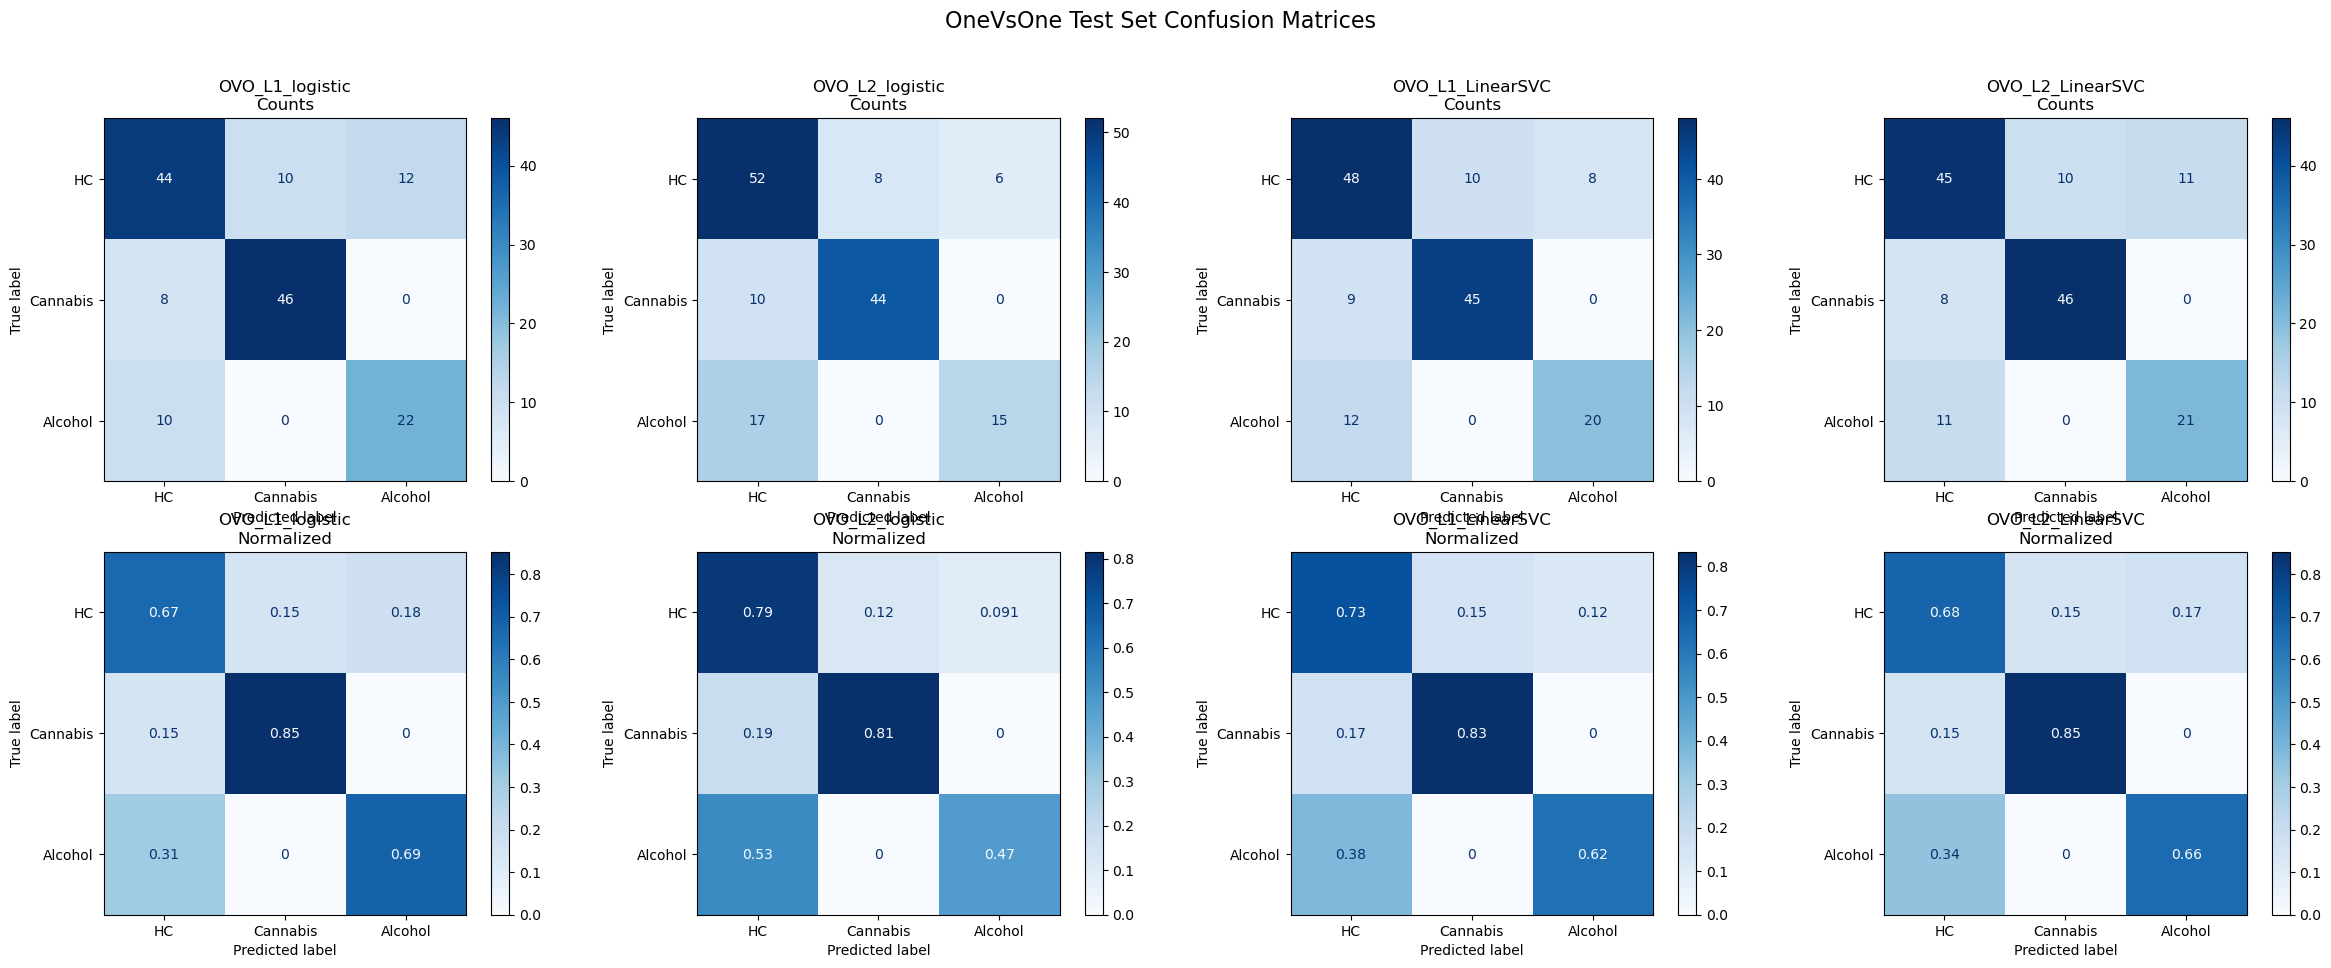


Finished 3-Way Evaluation (OneVsOne)



In [21]:
# === 3-Way Classification: Evaluation (OneVsOne Strategy - No Scaling) ===

print("\n" + "="*40)
print("Starting 3-Way Evaluation (OneVsOne - Using Best Alphas)")
print("="*40 + "\n")

# Check if best alphas exist
if 'ovo_best_alphas' not in locals() or not ovo_best_alphas:
    raise NameError("OVO Grid search cell must be run first to define 'ovo_best_alphas'.")

# --- Define the 4 Final OVO Classifiers with their Best Alphas ---
classifiers_ovo = {}
for variant in sgd_variants:
    variant_name = variant['name']
    best_alpha = ovo_best_alphas.get(variant_name)
    if best_alpha is None:
         print(f"Warning: No best alpha found for OVO {variant_name}, skipping evaluation.")
         continue

    final_sgd = SGDClassifier(
        loss=variant['loss'],
        penalty=variant['penalty'],
        alpha=best_alpha,
        random_state=RANDOM_STATE_MULTICLASS,
        max_iter=MAX_ITER_TRAINING,
        class_weight='balanced'
    )
    classifiers_ovo[f"OVO_{variant_name}"] = OneVsOneClassifier(final_sgd)

print("Defined final OVO classifiers:")
for name in classifiers_ovo: print(f"  {name}")

# --- Instantiate and Run MultiClassEvaluator ---
if not classifiers_ovo:
    print("No valid OVO classifiers defined, skipping evaluation.")
else:
    multi_evaluator_ovo = MultiClassEvaluator(classifiers_ovo)

    print("\nRunning Multi-Class Evaluation Pipeline (OVO)...")
    cv_results_ovo, fitted_ovo_models_dict = multi_evaluator_ovo.evaluate_cv(
        X_train=three_X_train, # Unscaled 3-class train data
        y_train=three_y_train,
        n_splits=CLASSIFICATION_CV_FOLDS,
        random_state_kfold=RANDOM_STATE_KFOlD
    )

    # --- Save Final Models ---
    multi_evaluator_ovo.save_models(THREECLASS_ONEVONE_PKL) # Use OVO path

    # --- Display CV Metrics ---
    ovo_metrics_df = multi_evaluator_ovo.get_cv_metrics_summary()
    print("\nOVO Cross-Validation Metrics Summary:")
    display(ovo_metrics_df)

    # --- Test Set Evaluation & Plotting ---
    print("\n--- 3-Way Hold-Out Test Set Evaluation (OVO) ---")
    if fitted_ovo_models_dict and three_X_test.size > 0:
        # Create figure for confusion matrices
        n_models_ovo = len(fitted_ovo_models_dict)
        fig_cm_ovo, axes_cm_ovo = plt.subplots(2, n_models_ovo, figsize=(6 * n_models_ovo, 10), squeeze=False)

        col_idx = 0
        for model_name, fitted_model in fitted_ovo_models_dict.items():
             print(f"\n--- Evaluating: {model_name} ---")
             if fitted_model:
                 try:
                    preds_test = fitted_model.predict(three_X_test)
                    test_acc = accuracy_score(three_y_test, preds_test)
                    print(f"  Test Accuracy: {test_acc:.4f}")

                    # Classification Report
                    target_names = MULTICLASS_LABELS if 'MULTICLASS_LABELS' in locals() else [f'Class {i}' for i in np.unique(three_y_train)]
                    print("  Test Classification Report:")
                    print(classification_report(three_y_test, preds_test, target_names=target_names, zero_division=0))

                    # Plot Confusion Matrix (Counts)
                    ConfusionMatrixDisplay.from_predictions(
                        three_y_test, preds_test, ax=axes_cm_ovo[0, col_idx],
                        display_labels=target_names, cmap=plt.cm.Blues
                    )
                    axes_cm_ovo[0, col_idx].set_title(f'{model_name}\nCounts')

                    # Plot Confusion Matrix (Normalized)
                    ConfusionMatrixDisplay.from_predictions(
                        three_y_test, preds_test, ax=axes_cm_ovo[1, col_idx],
                        display_labels=target_names, cmap=plt.cm.Blues, normalize='true'
                    )
                    axes_cm_ovo[1, col_idx].set_title(f'{model_name}\nNormalized')
                    col_idx += 1

                 except Exception as e:
                     print(f"  Error during test set evaluation for {model_name}: {e}")
                     axes_cm_ovo[0, col_idx].set_title(f'{model_name}\nEval Error')
                     axes_cm_ovo[1, col_idx].set_title(f'{model_name}\nEval Error')
                     col_idx +=1
             else:
                 print(f"  Skipping evaluation (model fitting failed).")
                 axes_cm_ovo[0, col_idx].set_title(f'{model_name}\nNo Model')
                 axes_cm_ovo[1, col_idx].set_title(f'{model_name}\nNo Model')
                 col_idx +=1


        fig_cm_ovo.suptitle('OneVsOne Test Set Confusion Matrices', fontsize=16)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        fig_cm_ovo.savefig(MULTICLASS_OVO_CM_FIG, format='svg', dpi=1200, bbox_inches='tight') # Use OVO path
        print(f"\nSaved OVO Confusion Matrix plot to {MULTICLASS_OVO_CM_FIG}")
        plt.show()

    elif not fitted_ovo_models_dict:
        print("No final OVO models were fitted successfully.")
    else: # Test data empty
        print("Test data is empty. Cannot evaluate on test set.")


print("\n" + "="*40)
print("Finished 3-Way Evaluation (OneVsOne)")
print("="*40 + "\n")